# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

In [25]:
# import necessary libraries and packages
import pandas as pd
import numpy as np
import math
import json
from matplotlib import pyplot as plt
import seaborn as sns
from tqdm import tqdm
import time as time
from time import sleep
pd.options.display.max_columns=30


from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LinearRegression, ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn.metrics import mean_squared_error, mean_absolute_error


## I. Business Understanding

### Project Goals
In this project, I will answer the following questions:
1. For age groups, income groups, and genders, do BOGO or discount offers have higher rates of success? Which have higher amounts of spending?
2. How does difficulty, duration, and reward impact a customers spending? 
3. Under which offer type (BOGO, DISCOUNT, INFORMATIONAL) do customers spend the most?
4. Does sending more offers increase the liklihood of an offer being completed?


Lastly, I will create a model that will predict the amount spent after receiving an offer
5. Create a machine learning model that will predict how much a user with certain demographics will spend after receiving a given offer_type.


## II. Data Understanding

In this step, I will explore the value counts and distributions of the variables in each of the tables

In [3]:
plt.style.use('fivethirtyeight')

In [2]:
# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

In [128]:
portfolio

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7
5,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2
6,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837
8,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d
9,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5


In [129]:
profile.head()

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


In [130]:
transcript.head()

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


In [131]:
# view shape of datasets
print('portfolio shape: ', portfolio.shape,
      '\nprofile shape: ', profile.shape, 
      '\ntranscript shape: ', transcript.shape)

portfolio shape:  (10, 6) 
profile shape:  (17000, 5) 
transcript shape:  (306534, 4)


### Portfolio DataFrame Understanding

In [132]:
print('portfolio_null_values:\n', portfolio.isnull().sum())

portfolio_null_values:
 reward        0
channels      0
difficulty    0
duration      0
offer_type    0
id            0
dtype: int64


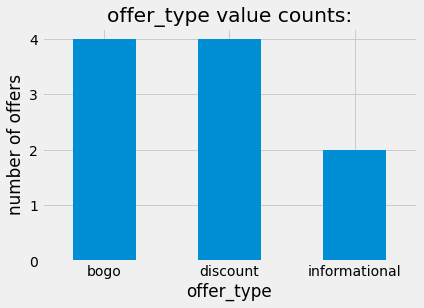

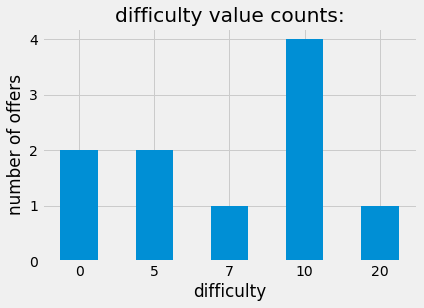

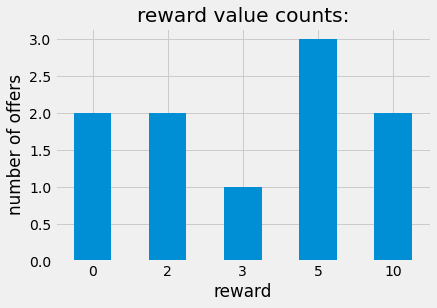

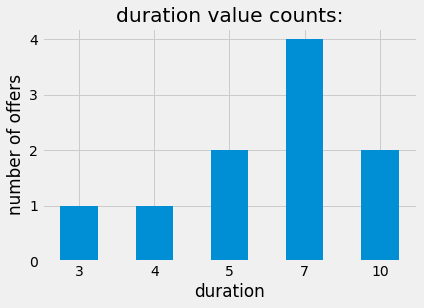

In [133]:
# How many of each offer type do we have? 

cols = ['offer_type', 'difficulty', 'reward', 'duration']

for col in cols:
    portfolio[col].value_counts().sort_index().plot.bar(title=col + " value counts:")
    plt.xlabel(col)
    plt.xticks(rotation=0)
    plt.ylabel('number of offers')
    plt.show()


### Profile DataFrame Understanding

In [134]:
profile.describe()

,age,became_member_on,income
count,17000.000000,1.700000e+04,14825.000000
mean,62.531412,2.016703e+07,65404.991568
std,26.738580,1.167750e+04,21598.299410
min,18.000000,2.013073e+07,30000.000000
25%,45.000000,2.016053e+07,49000.000000
50%,58.000000,2.017080e+07,64000.000000
75%,73.000000,2.017123e+07,80000.000000
max,118.000000,2.018073e+07,120000.000000


In [135]:
print('profile_null_values:\n', profile.isnull().sum())

profile_null_values:
 gender              2175
age                    0
id                     0
became_member_on       0
income              2175
dtype: int64


In [136]:
age_118_idx = profile[profile['age'] == 118].index

gender_null_idx = profile[profile['gender'].isnull()].index

income_null_idx = profile[profile['income'].isnull()].index

set(age_118_idx) == set(gender_null_idx) == set(income_null_idx)

True

As I expected, the customers with null values in income nad gender also have an age of 118, which indicates that 118 was likely a placeholder to mean "unknown."

### Let's see how the demographic variables are distributed

<AxesSubplot:>

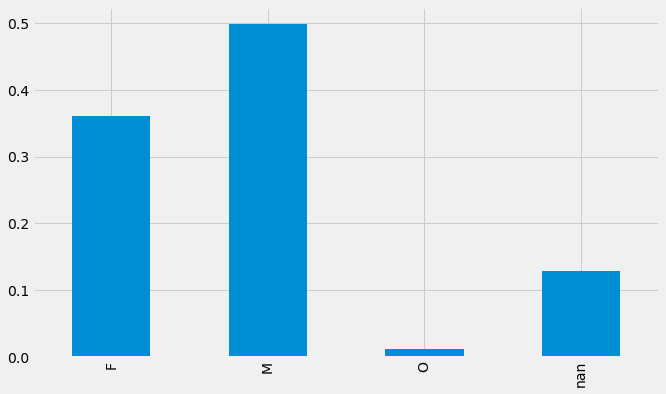

In [137]:
profile['gender'].value_counts(dropna=False, normalize=True).sort_index().plot.bar(figsize=(10,6))

In [138]:
def plot_hist(df, col, bin_size, x_range):
    """plots a histogram for a given column
    INPUTS
    df: df
    col (str): column in df
    bins (int): number of bins
    x_range (tup): range of x_values
    OUTPUTS
    histogram
    """
    rge = x_range[1] - x_range[0]
    bins = int(rge/bin_size)
    profile[col].plot.hist(figsize=(10,6), bins=bins, range=x_range, alpha=0.8)
    plt.xticks(ticks=np.arange(x_range[0], x_range[1]+1, bin_size))
    plt.xlabel(col)
    plt.title(col.title() + ' Histogram')
    plt.show()
    

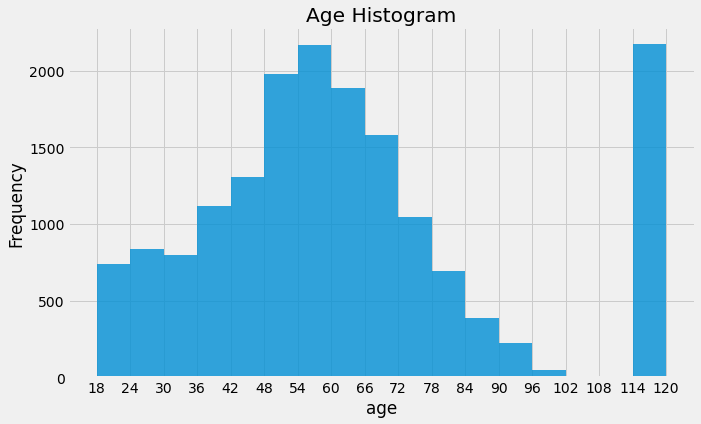

In [139]:
plot_hist(df=profile, col='age', bin_size=6, x_range=(18,120))

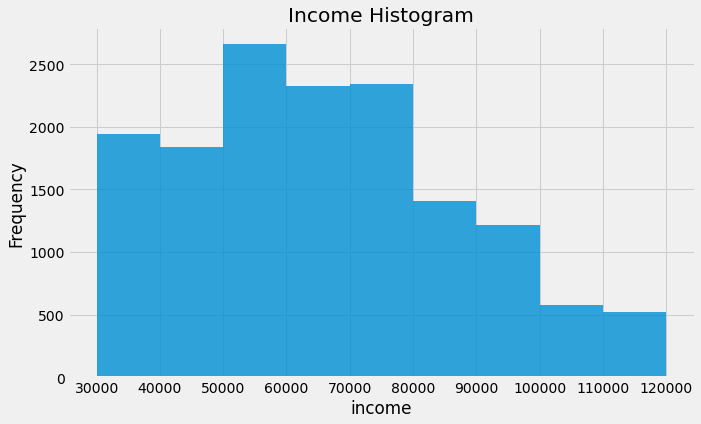

In [140]:
plot_hist(df=profile, col='income', bin_size=10000, x_range=(30000, 120000))

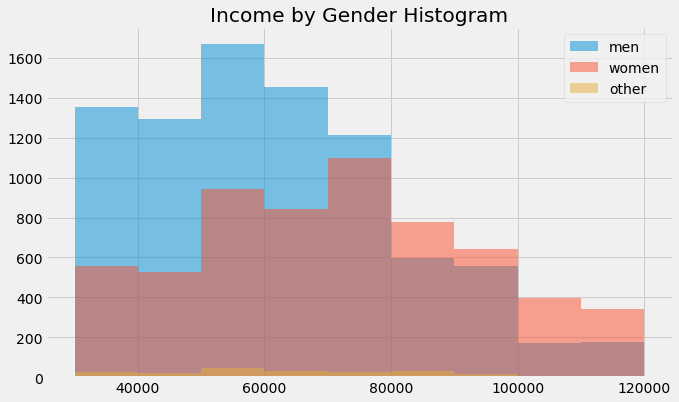

In [141]:
fig, ax = plt.subplots(figsize=(10,6))

bins = 9

men = profile.loc[profile['gender'] == 'M', 'income']
women = profile.loc[profile['gender'] == 'F', 'income']
other = profile.loc[profile['gender'] == 'O', 'income']

ax.hist(men, bins=9, range=(30000,120000), alpha=0.5, label='men')
ax.hist(women, bins=9, range=(30000,120000), alpha=0.5, label='women')
ax.hist(other, bins=9, range=(30000,120000), alpha=0.5, label='other')
ax.set_title('Income by Gender Histogram')
plt.legend()

In [142]:
profile.groupby('gender')['income'].median()

gender
F    71000.0
M    59000.0
O    62000.0
Name: income, dtype: float64

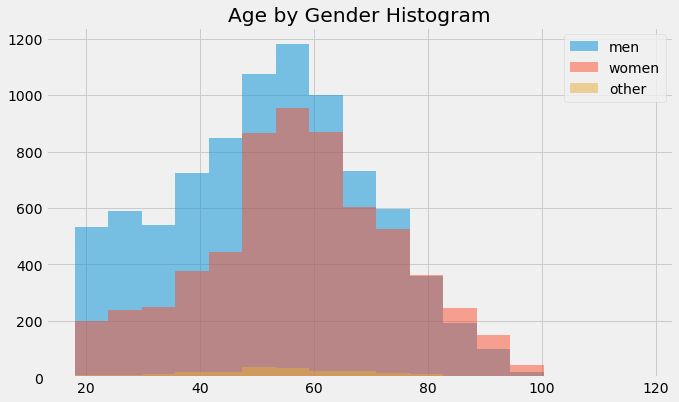

In [143]:
fig, ax = plt.subplots(figsize=(10,6))

bins=17

men = profile.loc[profile['gender'] == 'M', 'age']
women = profile.loc[profile['gender'] == 'F', 'age']
other = profile.loc[profile['gender'] == 'O', 'age']

ax.hist(men, bins=bins, range=(18,118), alpha=0.5, label='men')
ax.hist(women, bins=bins, range=(18,118), alpha=0.5, label='women')
ax.hist(other, bins=bins, range=(18,118), alpha=0.5, label='other')
ax.set_title('Age by Gender Histogram')
plt.legend()

In [144]:
profile.groupby('gender')['age'].median()

gender
F    58
M    53
O    55
Name: age, dtype: int64

381.0613743091652 44677.72038712164


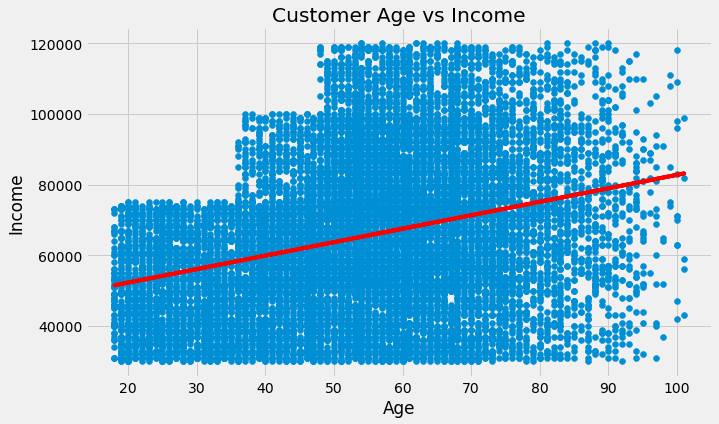

In [145]:
fig, ax = plt.subplots(figsize=(10,6))

data=profile.dropna()

X = data['age']
Y = data['income']
m, b = np.polyfit(X, Y, 1)
print(m, b)

ax.scatter(x=X, y=Y)
ax.plot(X, m*X+b, c='red')
ax.set_title('Customer Age vs Income')
ax.set_xlabel('Age')
ax.set_ylabel('Income')
ax.set_xticks(np.arange(20, 101, 10))

In [146]:
transcript.isnull().sum()

person    0
event     0
value     0
time      0
dtype: int64

In [147]:
transcript.shape

(306534, 4)

Text(0.5, 1.0, 'Event Types')

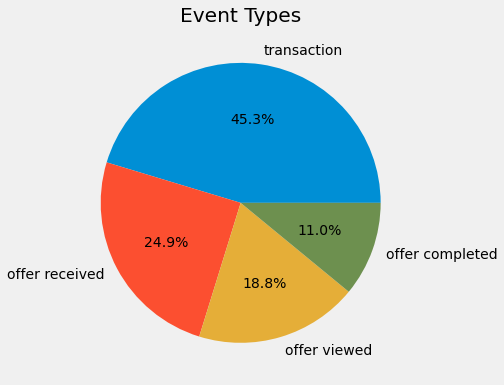

In [148]:
transcript['event'].value_counts(normalize=True).plot.pie(figsize=(10,6), autopct='%1.1f%%')
plt.ylabel('')
plt.title('Event Types')

In [150]:
transcript['person'].nunique()

17000

### Data Understanding Summary

#### Portfolio

1. There are 10 different offers - 2 informational, 4 bogo, 4
2. The offer difficulties range from \\$0 \(for informational offers\) to \\$20, the most common being \\$10.
3. The offer rewards range from \\$0 \(for informational offers to\) \\$10, the most common being \\$5.
4. The offer durations range from 3 days to 10 days, the most common being 7 days.

#### Profile
1. There are 170,000 customers
2. There are 2,175 customers with null values in income and gender.
3. Ages range from 18 to 118. However, it appears 118 is used as a place holder, most likely indicating "unknown/not given" as customers with that age also have null values for income and gender.
4. The variable became_member_on is formated as an int, but should be converted to a datetime object for us to make use of it.
5. Income ranges from 30k to 120k, with the median being 64k.
6. The median income for female customers is \\$71k, \\$59k for male customers, and \\$62k for customers who marked Other.
7. The median age for female customers is 58, for male customers 53, and 55 for customers who marked their gender as Other.
8. Age and Income are positively correlated.
9. There are no customers between 18 and 36 who make over \\$75k. There are no users under 48 who make more than 100k.

#### Transcript
1. There are 306,534 rows, with each row being one of four events: 'offer received', 'offer viewed', 'offer completed', or 'transaction'.
2. 45.3% of the rows are transactions, 24.9% are offer received, 18.8% are offer viewed events, and 11% are offer completed.
3. The value column is a dictionary that gives the offer_id for an "offer received", "offer viewed" or "offer completed" event, and a transaction amount if the event is a transaction. <br>We will want to clean this columnn in the next section.
4. The times range from 0 to 714, and indicate the hour that the event occured in. The experiment ran for about 30 days. 


## III. Data Preparation

In this section I will clean each of the tables so that I can answer my questions and prepare the data for my model.
<br><br>**Portfolio DataFrame**

1. Add a column "readable_id" which contains a unique id that is easier to read than the hash id.
2. One-hot encode the channels column: 'email', 'mobile', 'social' or 'web'.
3. One-hot encode the offer_type: "bogo", "discount", or "informational".

<br>**Profile DataFrame**

1. Convert "became_member_on" column to a datetime object.
2. Extract the year a member joined and store in the column "year_joined."
3. Replace the customers with age 118 with NaNs and drop the rows with null values. I decieded to drop these rows because these customers were missing data from all three demographic variables,<br>
and thus they wouldn't be helpful in answering my questions.
4. Create the column "age_group" with the following age groups: 18-24, 25-34, 35-44, 45-54, 55-65, 65-74, 75+.
5. Create the column "income_group" with the following income groups: 30-45k, 45-60k, 60-75k, 75-90k, 90-105k, 105-120k (ranges include the left endpoint and exclude the right endpoint).

<br>**Transcript**
1. Extract the offer id, amount, or reward from the dictioanry in the value column and store in its own column.
2. Drop the original value column

<br>**Create Master DataFrame**
1. Merge the profile and transaction datasets.
2. Merge the resulting dataset with the profile dataset.
3. Drop repeated columns and reorder for readability. 

In [44]:
def clean_portfolio(df=portfolio):
    # Create an ID column that is more readable than the id hash
    df['readable_id'] = ['BOGO - $10 - 7days', 'BOGO - $10 - 5days', 'INFO - $0 - 4days', 'BOGO - $5 - 7days',
                           'DISC - $20/\$5 - 10days', 'DISC - $7/\$3 - 7days', 'DISC - $10/\$2 - 10days', 'INFO - $0 - 3days',
                           'BOGO - $5 - 5days', 'DISC - \$10/\$2 - 7days']
    
    # Extract channels into their own columns one-hot encoded
    df['email'] = df['channels'].apply(lambda x: 1 if 'email' in x else 0)
    df['mobile'] = df['channels'].apply(lambda x: 1 if 'mobile' in x else 0)
    df['social'] = df['channels'].apply(lambda x: 1 if 'social' in x else 0)
    df['web'] = df['channels'].apply(lambda x: 1 if 'web' in x else 0)
    
  
    # Drop unneeded columns
    df.drop(columns=['channels'], inplace=True, errors='ignore')
   
    
    # Turn offer_type into a dummy variable
    new_df = pd.get_dummies(df, columns=['offer_type'], prefix='', prefix_sep='')
    new_df = pd.concat([new_df, df['offer_type']], axis=1)
    
    
    # Rename dummy columns
    new_df = new_df[['readable_id', 'id', 'offer_type', 'difficulty', 'reward', 'duration', 'email', 'mobile', 'social', 'web', 'bogo', 'discount', 'informational']]
    

    return new_df

clean_portfolio = clean_portfolio(df=portfolio)
clean_portfolio.to_csv('clean_portfolio.csv', index=False)


In [45]:
clean_portfolio.head(10)

,readable_id,id,offer_type,difficulty,reward,duration,email,mobile,social,web,bogo,discount,informational
0,BOGO - $10 - 7days,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,10,7,1,1,1,0,1,0,0
1,BOGO - $10 - 5days,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10,10,5,1,1,1,1,1,0,0
2,INFO - $0 - 4days,3f207df678b143eea3cee63160fa8bed,informational,0,0,4,1,1,0,1,0,0,1
3,BOGO - $5 - 7days,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5,5,7,1,1,0,1,1,0,0
4,DISC - $20/\$5 - 10days,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,20,5,10,1,0,0,1,0,1,0
5,DISC - $7/\$3 - 7days,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,7,3,7,1,1,1,1,0,1,0
6,DISC - $10/\$2 - 10days,fafdcd668e3743c1bb461111dcafc2a4,discount,10,2,10,1,1,1,1,0,1,0
7,INFO - $0 - 3days,5a8bc65990b245e5a138643cd4eb9837,informational,0,0,3,1,1,1,0,0,0,1
8,BOGO - $5 - 5days,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5,5,5,1,1,1,1,1,0,0
9,DISC - \$10/\$2 - 7days,2906b810c7d4411798c6938adc9daaa5,discount,10,2,7,1,1,0,1,0,1,0


In [111]:
def clean_profile(df=profile):
    """Cleans the profile dataframe
    1. Converts dates to datetime objects
    2. Extracts the year the member joined
    2. Sets age 118 to np.nan
    3. Creates columns for age_groups and income_groups.
    INPUT:
    profile dataframe
    OUTPUT:
    clean_profile dataframe
    """
    
    # Convert column to datetime object
    df['became_member_on'] = pd.to_datetime(df['became_member_on'], format='%Y%m%d')
    
    # Extract the year 
    df['year_joined'] = pd.DatetimeIndex(df['became_member_on']).year
    
    # Change 118 to nan. This was likely used as a placeholder to indicate unknown.
    # Customers with this age also had null values for income and gender
    df.loc[df['age'] == 118] = np.nan
    
    orig_num_rows = df.shape[0]
    print('Original Number of Rows: ', orig_num_rows)
        
    # Drop nulls - We do not have any demographic information regarding these customers to work with
    df = df.dropna(axis=0)
            
    final_num_rows = df.shape[0]
    print('Final Number of Rows: ', final_num_rows)
    print('Null Values Dropped: ', orig_num_rows - final_num_rows)
    
    
    # create age groups 
    cond_lst = [df['age'].between(18,24),
            df['age'].between(25,34),
            df['age'].between(35,44),
            df['age'].between(45,54),
            df['age'].between(55,64),
            df['age'].between(65,74),
            df['age'].between(75,117)]
    
    choice_lst = ["18-24", "25-34", "35-44", "45-54", "55-64", "65-74", "75+"]
    df['age_group'] = np.select(condlist = cond_lst, choicelist=choice_lst)
    

    cond_lst = [df['income'].between(30000,44999),
                df['income'].between(45000,59999),
                df['income'].between(60000,74999),
                df['income'].between(75000,89999),
                df['income'].between(90000,104999),
                df['income'].between(105000,120000)]
    choice_lst = ["30-45k", "45-60k", "60-75k", "75-90k", "90-105k", "105k+"]

    df['income_group'] = np.select(condlist = cond_lst, choicelist=choice_lst)    
    
    
    return df

clean_profile = clean_profile(df=profile)
clean_profile.to_csv('clean_profile.csv',index=False)

Original Number of Rows:  17000
Final Number of Rows:  14825
Null Values Dropped:  2175


C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\ipykernel_launcher.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\ipykernel_launcher.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [112]:
def extract_offer_id(row):
    """Helper function to be used in the clean_transcript function below:
    Input: row of the transcript column
    Output: offer_id for an offer received, offer viewed, or offer completed event
    """
    if row['event'] == 'offer viewed' or row['event'] == 'offer received':
        return row['value']['offer id']
    elif row['event'] == 'offer completed':
        return row['value']['offer_id']
    else:
        return np.nan

def clean_transcript(df=transcript):
    """Cleans the transcript dataframe
    1. Extracts the transaction amt, reward, or offer_id from the dictionary in the value column
    2. Drops the old value column
    INPUT: transcript df
    OUTPUT: clean_transcript df
    """
    
    df['transaction_amt'] = df.apply(lambda row: row['value']['amount'] if 'amount' in row['value'].keys() else np.nan, axis=1)
    df['offer_id'] = df.apply(extract_offer_id, axis=1)
    df['reward'] = df.apply(lambda row: row['value']['reward'] if 'reward' in row['value'].keys() else np.nan, axis=1)
    
    df = df.drop(columns=['value'])
    
    return df

clean_transcript = clean_transcript(df=transcript)
clean_transcript.to_csv('clean_transcript.csv', index=False)

In [58]:
def create_merged_df(portfolio_df=clean_portfolio, profile_df=clean_profile, transcript_df=clean_transcript):
    """Merges the three datasets to one master df
    INPUTS
    portfolio_df: dataframe of offers including and 'offer_id' column with offer id's
    profile_df: dataframe of customer demographic data including an 'id' column with customer id's
    transcript_df: dataframe of every event during experiment including offer_id column and customer_id column
    
    OUTPUTS
    master_df: a dataframe of every event during experiment with demographic data
    """
    
    # merge transcript_df and profile_df on customer id
    df = pd.merge(profile_df, transcript_df, how='left', left_on='id', right_on='person')
    
    # drop 'id' column because this is the same as the 'person' column
    df.drop(columns=['id'], inplace=True)
    
    # merge above df with portfolio_df to include information about offers
    merged_df = pd.merge(df, portfolio_df, how='left', left_on='offer_id', right_on='id')
    
    # drop reward_x column, as we only need the reward in the offer_received events and drop 'id' and 'offer_id' as we have the readable_id' now.
    merged_df.drop(columns=['reward_x', 'id', 'offer_id'], inplace=True)
    
    merged_df = merged_df[['person', 'gender', 'age', 'became_member_on', 'income', 'year_joined', 'age_group', 'income_group', 'event', 'time', 'transaction_amt',
                          'readable_id', 'offer_type', 'difficulty', 'reward_y', 'duration', 'email', 'mobile', 'social', 'web', 'bogo', 'discount', 'informational']]
    
    merged_df.rename(columns={'reward_y':'reward'})
    
    return merged_df

merged_df = create_merged_df()
merged_df.head()

,person,gender,age,became_member_on,income,year_joined,age_group,income_group,event,time,transaction_amt,readable_id,offer_type,difficulty,reward_y,duration,email,mobile,social,web,bogo,discount,informational
0,0610b486422d4921ae7d2bf64640c50b,F,55.0,2017-07-15,112000.0,2017.0,55-64,105k+,transaction,18,21.51,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0610b486422d4921ae7d2bf64640c50b,F,55.0,2017-07-15,112000.0,2017.0,55-64,105k+,transaction,144,32.28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0610b486422d4921ae7d2bf64640c50b,F,55.0,2017-07-15,112000.0,2017.0,55-64,105k+,offer received,408,NaN,BOGO - $5 - 7days,bogo,5.0,5.0,7.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0
3,0610b486422d4921ae7d2bf64640c50b,F,55.0,2017-07-15,112000.0,2017.0,55-64,105k+,offer received,504,NaN,INFO - $0 - 4days,informational,0.0,0.0,4.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0
4,0610b486422d4921ae7d2bf64640c50b,F,55.0,2017-07-15,112000.0,2017.0,55-64,105k+,transaction,528,23.22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
272757,e4052622e5ba45a8b96b59aba68cf068,F,62.0,2017-07-22,82000.0,2017.0,55-64,75-90k,offer completed,480,NaN,BOGO - $5 - 5days,bogo,5.0,5.0,5.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0
272758,e4052622e5ba45a8b96b59aba68cf068,F,62.0,2017-07-22,82000.0,2017.0,55-64,75-90k,transaction,486,19.47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
272759,e4052622e5ba45a8b96b59aba68cf068,F,62.0,2017-07-22,82000.0,2017.0,55-64,75-90k,offer viewed,546,NaN,BOGO - $5 - 5days,bogo,5.0,5.0,5.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0
272760,e4052622e5ba45a8b96b59aba68cf068,F,62.0,2017-07-22,82000.0,2017.0,55-64,75-90k,offer received,576,NaN,INFO - $0 - 4days,informational,0.0,0.0,4.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0


In [114]:
# will take a while to run
def group_transactions_by_offer(df = merged_df):
    """
    This function loops through the customers and does 4 things for each
    'offer received' event: 
    
    Let the "offer window" be defined as the time an offer was received
    to the "offer_valid_until" time. 
    
    1. Sums up all their transactions that were between the offer window
       and stores value in 'amt_spent_under_offer' column.
    2. Determines if a received offer was viewed and stores a 1 in the 
       column "offer_viewed" if so. A received offer was viewed if 
       there is an "offer viewed" event in the offer window AND it has
       the same readable_id.  
    3. Determines if a received offer was completed and stores a 1 in 
       the column "offer_completed" if so. A received offer was 
       completed if there was an "offer completed" event in the offer
       window AND the received offer was not informational.
    4. Creates a column "offer_successful" and places a 1 if the offer
       was both viewed AND completed.
       
    Lastly, it subsets only the offer received events, as they now contain
    all the information we need. 
    
    """
    # Initialize new columns
    df['amt_spent_under_offer'] = 0
    df['offer_completed'] = 0
    df['offer_viewed'] = 0
    df['offer_valid_until'] = np.nan
    df['num_offers'] = 0
    
    # Sets the offer_valid_until column with the time + duration*24 
    df.loc[df['event'] == 'offer received', 'offer_valid_until'] = (df.loc[df['event'] == 'offer received', 'time'] 
                                                                                  + df.loc[df['event'] == 'offer received', 'duration'] * 24)
    

    for person in tqdm(df['person'].unique(), desc='Progress'):
        # Create a dataframe of only 1 person's events
        customer_data = df.loc[df['person'] == person]
        
        # Create a df of the customers offer received events
        customer_received_offers = customer_data.loc[customer_data['event'] == 'offer received']
        
        # Create a df of the customers offer viewed events
        customer_viewed_offers = customer_data.loc[customer_data['event'] == 'offer viewed']
        
        # Createa a df of the customers completed offer events
        customer_completed_offers = customer_data.loc[customer_data['event'] == 'offer completed']
        
        # iterate through that customer's received offers
        for offer in customer_received_offers.itertuples():
            
            # Store some useful variables
            idx = offer.Index
            offer_start = offer.time 
            offer_end = offer.offer_valid_until
            offer_id = offer.readable_id
            
            # subset all transactions that occured in the offer window 
            # and sum the transaction_amt column
            amt_spent = customer_data.loc[(customer_data['time'].between(offer_start, offer_end))
                                          & (customer_data['event'] == 'transaction'), 'transaction_amt'].sum()
            
            # For the received offer, set the "amt_spent_under_offer" 
            # column to amt_spent
            df.at[idx, 'amt_spent_under_offer'] = amt_spent
            
            # iterate through the viewed offers
            for view in customer_viewed_offers.itertuples(index=False):
                # Check if offer viewed event meets conditions and if so
                # assign 1 to "offer_viewed" column at the received_offer
                # event.
                if (offer_start <= view.time 
                    and view.time <= offer_end 
                    and view.readable_id == offer_id):
                    # assign 1 in offer_viewed if true
                    df.at[idx, 'offer_viewed'] = 1
                    break
                    
            # Iterate through completed offers
            for completed in customer_completed_offers.itertuples(index=False):
                
                if (offer_start <= completed.time 
                    and completed.time <= offer_end 
                    and offer.informational ==  0 
                    and completed.readable_id == offer_id 
                    and amt_spent >= offer.difficulty):
                    
                    df.at[idx, 'offer_completed'] = 1
                    break
        
        # num_offer received
        num_offers = customer_received_offers.shape[0]
        df.loc[(df['person'] == person) 
               & (df['event'] == 'offer received'), 'num_offers'] = np.arange(0,num_offers)

    master_df = df.loc[df['event'] == 'offer received']
    
    # If an offer was viewed AND completed, we will consider that offer successful.
    master_df['offer_successful'] = ((master_df['offer_completed'] 
                                      + master_df['offer_viewed']) == 2).astype(int)
                    
    return master_df

master_df = group_transactions_by_offer()
master_df.to_csv('master_df.csv', index=False)

If you don't want to run the function, you can just use this:

In [97]:
master_df = pd.read_csv('master_df.csv')

In [99]:
num_offers_received = master_df.loc[master_df['event'] == 'offer received'].shape[0]
num_offers_viewed = master_df['offer_viewed'].sum()

# completed offers may have been viewed or not
num_offers_completed = master_df['offer_completed'].sum()

# A successful offer is one that was viewed and completed
num_offers_successful = master_df['offer_successful'].sum()

print('num_offers_received: ', num_offers_received)
print('num_offers_viewed: ', num_offers_viewed)
print('num_offers_completed: ', num_offers_completed)
print('num_offers_successful: ', num_offers_successful)

num_offers_received:  66501
num_offers_viewed:  49126
num_offers_completed:  32439
num_offers_successful:  26845


## IV. Evaluate the Results

### 1. For age groups, income groups, and genders, are BOGO or discount offers more successfully completed? Which have higher amounts of spending?

In [7]:
def plot_disc_bogo_success_bar(df = master_df, demographic = 'age_group'):
    
    grouped = df.groupby(['offer_type', demographic])['offer_successful'].mean().reset_index()
    
    pivot = pd.pivot(grouped, index=demographic, columns='offer_type', values='offer_successful').reset_index()

    pivot['discount-bogo'] = pivot['discount'] - pivot['bogo']

    pivot = pivot.drop(columns='informational')

    if demographic == 'income_group':
        mapping = {'30-45k':1, '45-60k':2, '60-75k':3, '75-90k':4, '90-105k':5, '105k+':6}
        key = pivot['income_group'].map(mapping)
        pivot = pivot.iloc[key.argsort()]

    fig, ax = plt.subplots(figsize=(12, 8))

    x = pivot[demographic] 
    y = pivot['discount-bogo']
    ax.bar(x=x, height=y, color=(pivot['discount-bogo']>0).map({True:'#008fd5', False:'#fc4f30'}))
    ax.set_title('Discount-BOGO Offer Success Rates')
    ax.set_xlabel(demographic)
    ax.set_ylabel('Success Rate Difference \n (Discount - BOGO)')
    ax.set_ylim(auto=True)
    plt.show()

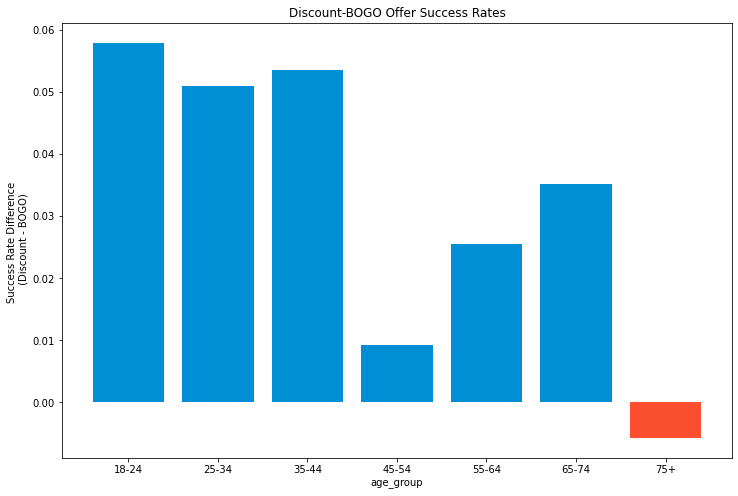

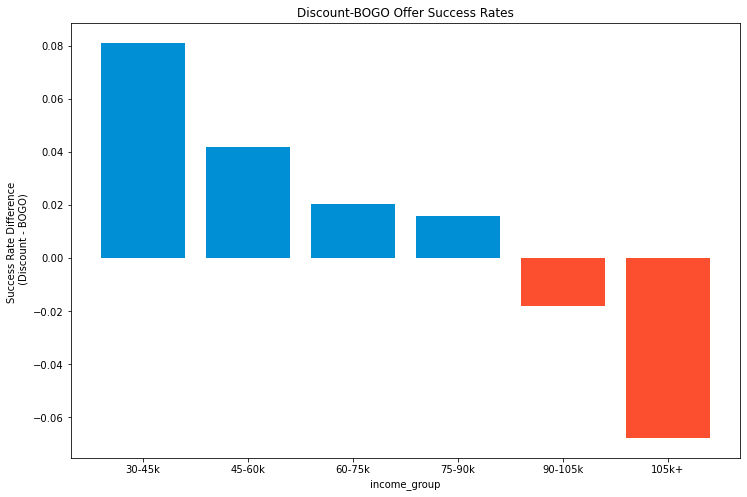

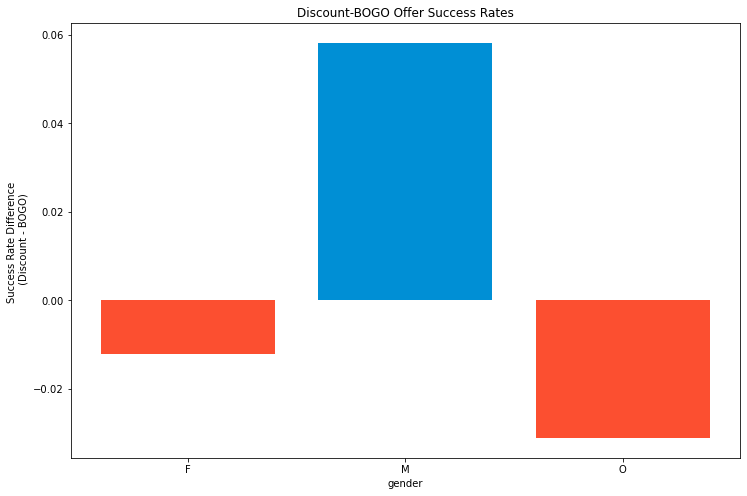

In [8]:
demographics = ['age_group', 'income_group', 'gender']

for demo in demographics:
    plot_disc_bogo_success_bar(df=master_df, demographic=demo)
    plt.show()

*Age
It appears discounts have an overall higher success rate for ages 18-74. For ages 18-44 discount offers are completed at about 6% higher than BOGO offers. The only age group where BOGO offers are completed at a higher success rate are 75+, and even this is less than 1%.


In [9]:
def plot_disc_bogo_amount_diff_bar(df = master_df, demographic = 'age_group'):
    viewed_offers = df.loc[df['offer_viewed'] == 1]
    pivot = pd.pivot(viewed_offers.groupby(['offer_type', demographic])['amt_spent_under_offer'].mean().reset_index(), index=demographic, columns='offer_type', values='amt_spent_under_offer').reset_index()

    pivot['discount-bogo'] = pivot['discount'] - pivot['bogo']

    pivot = pivot.drop(columns='informational')

    if demographic == 'income_group':
        mapping = {'30-45k':1, '45-60k':2, '60-75k':3, '75-90k':4, '90-105k':5, '105k+':6}
        key = pivot['income_group'].map(mapping)
        pivot = pivot.iloc[key.argsort()]

    fig, ax = plt.subplots(figsize=(12, 8))

    x = pivot[demographic] 
    y = pivot['discount-bogo']
    ax.bar(x=x, height=y, color=(pivot['discount-bogo']>0).map({True:'#008fd5', False:'#fc4f30'}))
    ax.set_title('Amount Spent Difference: Discount-BOGO')
    ax.set_xlabel(demographic)
    ax.set_ylabel(' Difference in Spending \n (Discount - BOGO)')
    ax.set_ylim(auto=True)
    plt.show()

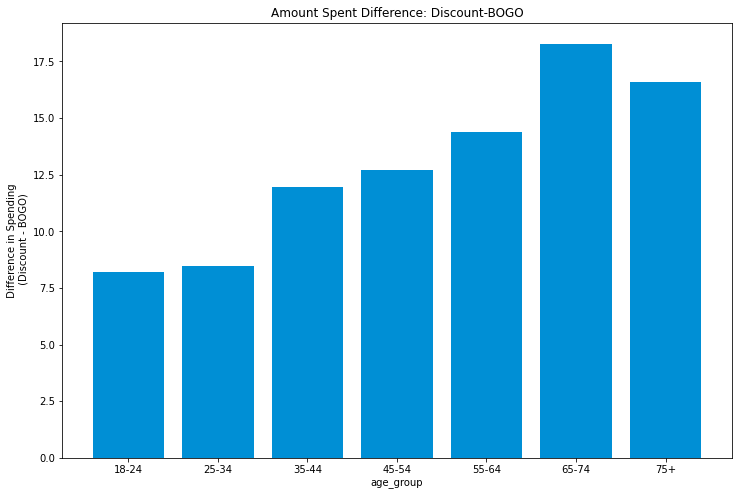

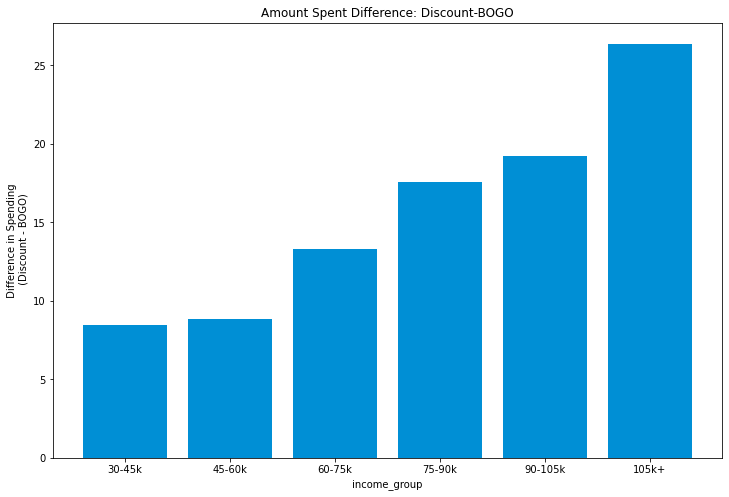

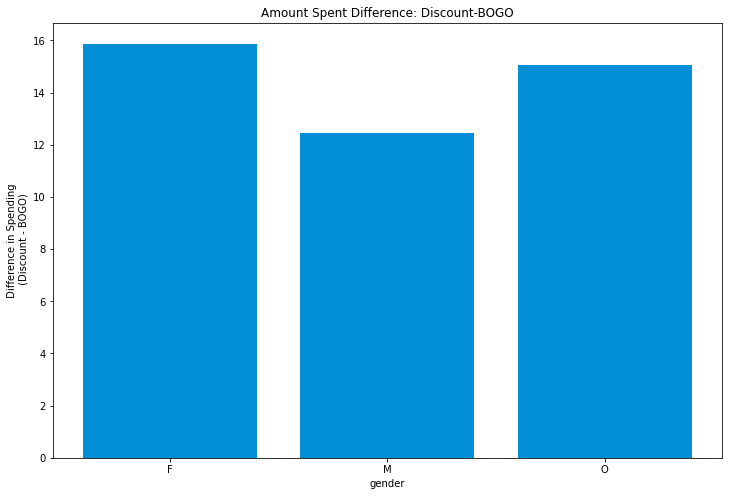

In [10]:
demographics = ['age_group', 'income_group', 'gender']

for demo in demographics:
    plot_disc_bogo_amount_diff_bar(df=master_df, demographic=demo)
    plt.show()

Discount offers as a whole seem to elicit more spending from customers than BOGO offers across all demographics. 

### 2. How does difficulty, duration, and reward impact a customers spending?

In [11]:
master_df

,person,gender,age,became_member_on,income,year_joined,age_group,income_group,event,time,transaction_amt,readable_id,offer_type,difficulty,reward_y,duration,email,mobile,social,web,bogo,discount,informational,amt_spent_under_offer,offer_completed,offer_viewed,offer_valid_until,offer_successful
0,0610b486422d4921ae7d2bf64640c50b,F,55.0,2017-07-15,112000.0,2017.0,55-64,105k+,offer received,408,NaN,BOGO - $5 - 7days,bogo,5.0,5.0,7.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,23,1,0,576.0,0
1,0610b486422d4921ae7d2bf64640c50b,F,55.0,2017-07-15,112000.0,2017.0,55-64,105k+,offer received,504,NaN,INFO - $0 - 4days,informational,0.0,0.0,4.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,23,0,0,600.0,0
2,78afa995795e4d85b5d9ceeca43f5fef,F,75.0,2017-05-09,100000.0,2017.0,75+,90-105k,offer received,0,NaN,BOGO - $5 - 7days,bogo,5.0,5.0,7.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,37,1,1,168.0,1
3,78afa995795e4d85b5d9ceeca43f5fef,F,75.0,2017-05-09,100000.0,2017.0,75+,90-105k,offer received,168,NaN,INFO - $0 - 3days,informational,0.0,0.0,3.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,49,0,1,240.0,0
4,78afa995795e4d85b5d9ceeca43f5fef,F,75.0,2017-05-09,100000.0,2017.0,75+,90-105k,offer received,408,NaN,BOGO - $10 - 7days,bogo,10.0,10.0,7.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,48,1,1,576.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66496,9dc1421481194dcd9400aec7c9ae6366,F,83.0,2016-03-07,50000.0,2016.0,75+,45-60k,offer received,576,NaN,BOGO - $10 - 7days,bogo,10.0,10.0,7.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,58,1,1,744.0,1
66497,e4052622e5ba45a8b96b59aba68cf068,F,62.0,2017-07-22,82000.0,2017.0,55-64,75-90k,offer received,0,NaN,DISC - $7/\$3 - 7days,discount,7.0,3.0,7.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,68,1,1,168.0,1
66498,e4052622e5ba45a8b96b59aba68cf068,F,62.0,2017-07-22,82000.0,2017.0,55-64,75-90k,offer received,336,NaN,INFO - $0 - 4days,informational,0.0,0.0,4.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0,0,0,432.0,0
66499,e4052622e5ba45a8b96b59aba68cf068,F,62.0,2017-07-22,82000.0,2017.0,55-64,75-90k,offer received,408,NaN,BOGO - $5 - 5days,bogo,5.0,5.0,5.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,50,1,0,528.0,0


In [12]:
master_df['readable_id'].value_counts().sort_index()

BOGO - $10 - 5days         6593
BOGO - $10 - 7days         6683
BOGO - $5 - 5days          6576
BOGO - $5 - 7days          6685
DISC - $10/\$2 - 10days    6652
DISC - $20/\$5 - 10days    6726
DISC - $7/\$3 - 7days      6655
DISC - \$10/\$2 - 7days    6631
INFO - $0 - 3days          6643
INFO - $0 - 4days          6657
Name: readable_id, dtype: int64

<AxesSubplot:xlabel='offer_type,duration'>

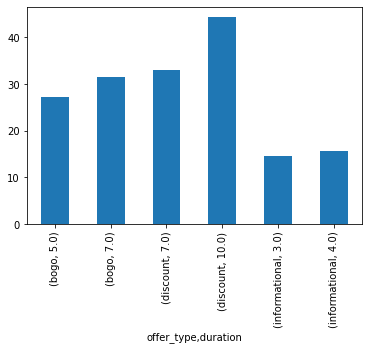

In [13]:
master_df.groupby(['offer_type', 'duration'])['amt_spent_under_offer'].mean().plot.bar()

Unsurprisingly, a offers with a longer duration had more spending under them 

<AxesSubplot:xlabel='offer_type,difficulty'>

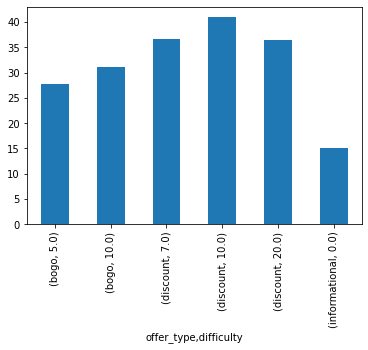

In [14]:
master_df.groupby(['offer_type', 'difficulty'])['amt_spent_under_offer'].mean().plot.bar()

For BOGO offers, a difficulty of $10 had more spenmding than BOGO offers with difficulty $5. 
Among discount offers, a difficulty of $10 had more than $7 and $20.


<AxesSubplot:xlabel='reward_y'>

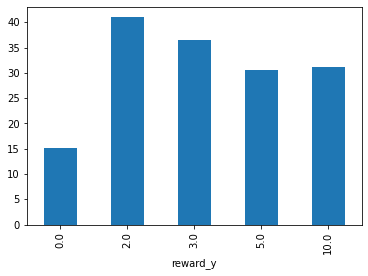

In [15]:
master_df.groupby(['reward_y'])['amt_spent_under_offer'].mean().plot.bar()

### Creating a model to predict spending after receiving a given offer

In [116]:
master_df
viewed_offers = master_df.loc[master_df['offer_viewed'] == 1]
features = viewed_offers[['gender', 'age_group', 'income_group', 'year_joined', 'readable_id', 'email', 'mobile', 'social', 'web', 'num_offers']]

X = pd.get_dummies(features, columns = ['readable_id', 'year_joined', 'gender', 'age_group', 'income_group'], prefix='', prefix_sep='')

y = viewed_offers['amt_spent_under_offer']

X.shape, y.shape

((49126, 37), (49126,))

In [117]:
X

,email,mobile,social,web,num_offers,BOGO - $10 - 5days,BOGO - $10 - 7days,BOGO - $5 - 5days,BOGO - $5 - 7days,DISC - $10/\$2 - 10days,DISC - $20/\$5 - 10days,DISC - $7/\$3 - 7days,DISC - \$10/\$2 - 7days,INFO - $0 - 3days,INFO - $0 - 4days,...,M,O,18-24,25-34,35-44,45-54,55-64,65-74,75+,105k+,30-45k,45-60k,60-75k,75-90k,90-105k
6,1.0,1.0,0.0,1.0,0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1
11,1.0,1.0,1.0,0.0,1,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1
16,1.0,1.0,1.0,0.0,2,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1
18,1.0,1.0,1.0,1.0,3,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1
24,1.0,1.0,0.0,1.0,0,0,0,0,0,0,0,0,1,0,0,...,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
272716,1.0,1.0,1.0,0.0,2,0,0,0,0,0,0,0,0,1,0,...,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0
272728,1.0,1.0,1.0,1.0,0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0
272734,1.0,1.0,0.0,1.0,1,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0
272741,1.0,1.0,1.0,0.0,2,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0


In [118]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=23)

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(39300, 37) (39300,) (9826, 37) (9826,)


In [119]:
lr = LinearRegression(normalize=True)

lr.fit(X_train, y_train)

lr.score(X_test, y_test)



0.0932839412508224

In [24]:
lr = LinearRegression()

params = {'normalize':[True, False]}
gs_lr = GridSearchCV(estimator=lr,
                    param_grid=params,
                    scoring = 'neg_mean_squared_error')



gs_lr.fit(X_train, y_train)

best_lr = gs_lr.best_estimator_
print(best_lr)

lr_preds = best_lr.predict(X_test)

mse = mean_squared_error(y_test, lr_preds)
mae = mean_absolute_error(y_test, lr_preds)

print('mean_squared_error:', mse)
print('mean_absolute_error:', mae)

pd.DataFrame({'features':X.columns, 'coefficients':best_lr.coef_}).sort_values('coefficients', ascending=False)

LinearRegression()
mean_squared_error: 3167.4833701372017
mean_absolute_error: 26.34833783444156


,features,coefficients
26,2016.0,1.549703e+01
25,2015.0,1.194798e+01
4,duration,4.595796e+00
40,30-45k,2.564052e+00
31,O,1.838844e+00
29,F,1.766977e+00
17,DISC - $10/\$2 - 10days,1.734240e+00
44,90-105k,1.710652e+00
34,35-44,1.643395e+00
6,mobile,1.151567e+00


In [75]:
params = {'alpha' : np.logspace(-3, 2, 10),
         'l1_ratio': np.linspace(0, 1, 5)}
gs_en = GridSearchCV(estimator=ElasticNet(max_iter=5000, tol=0.001), param_grid = params, scoring='neg_mean_absolute_error')

gs_en.fit(X_train, y_train)



C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 52482660.48196758, tolerance: 117393.5987622137
  positive)
C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 52458907.05176744, tolerance: 117953.80495162214
  positive)
C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 53273881.98486406, tolerance: 119269.1847479644
  positive)
C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to

GridSearchCV(estimator=ElasticNet(max_iter=5000, tol=0.001),
             param_grid={'alpha': array([1.00000000e-03, 3.59381366e-03, 1.29154967e-02, 4.64158883e-02,
       1.66810054e-01, 5.99484250e-01, 2.15443469e+00, 7.74263683e+00,
       2.78255940e+01, 1.00000000e+02]),
                         'l1_ratio': array([0.  , 0.25, 0.5 , 0.75, 1.  ])},
             scoring='neg_mean_absolute_error')

In [109]:
best_en = gs_en.best_estimator_
print(best_en)

en_preds = best_en.predict(X_test)

en_training_preds = best_en.predict(X_train)



print('training mean_abs_error:', mean_absolute_error(y_train, en_training_preds))
print('mean_abs_error:', mean_absolute_error(y_test, en_preds))



ElasticNet(alpha=0.046415888336127795, l1_ratio=0.75, max_iter=5000, tol=0.001)
training mean_abs_error: 26.347952893269152
mean_abs_error: 26.304850297309365


In [110]:
print('r2:', best_en.score(X_test, y_test))

r2: 0.095020213606546


In [108]:
master_df['amt_spent_under_offer'].mean()

30.268672651539074

In [15]:
model = KNeighborsRegressor()
params = {'knn__n_neighbors':np.arange(5, 96, 10)}
print(params)

pipeline = Pipeline([('normalizer', Normalizer()),
                   ('knn', model)])

gs = GridSearchCV(estimator=pipeline, param_grid=params, n_jobs=-1, scoring='neg_mean_absolute_error')


gs.fit(X_train, y_train)




{'knn__n_neighbors': array([ 5, 15, 25, 35, 45, 55, 65, 75, 85, 95])}


GridSearchCV(estimator=Pipeline(steps=[('normalizer', Normalizer()),
                                       ('knn', KNeighborsRegressor())]),
             n_jobs=-1,
             param_grid={'knn__n_neighbors': array([ 5, 15, 25, 35, 45, 55, 65, 75, 85, 95])},
             scoring='neg_mean_squared_error')

In [16]:
best_knn = gs.best_estimator_
print(best_knn)
knn_preds = best_knn.predict(X_test)
mse = mean_squared_error(y_test, knn_preds)
mae = mean_absolute_error(y_test, knn_preds)
print('mean_squared_error:', mse)
print('mean_absolute_error:', mae)

Pipeline(steps=[('normalizer', Normalizer()),
                ('knn', KNeighborsRegressor(n_neighbors=55))])
mean_squared_error: 3309.6489493383215
mean_absolute_error: 27.91738245471199


In [400]:
rf = RandomForestRegressor()

rf.fit(X_train, y_train)
rf_preds = rf.predict(X_test)

params = {'n_estimators':np.arange(100,901,400),
          'max_features': ['auto', 'sqrt'],
          'min_samples_split':[2,5,10],
          'min_samples_leaf':np.arange(10,111,20)}

rs = RandomizedSearchCV(estimator = rf,
                 param_distributions = params,
                 scoring = 'neg_mean_absolute_error',
                 verbose=3,
                       cv=3,
                       n_iter=50)


rs.fit(X_train, y_train)

Fitting 3 folds for each of 50 candidates, totalling 150 fits
[CV] n_estimators=100, min_samples_split=10, min_samples_leaf=10, max_features=auto 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  n_estimators=100, min_samples_split=10, min_samples_leaf=10, max_features=auto, score=-26.161, total=   5.4s
[CV] n_estimators=100, min_samples_split=10, min_samples_leaf=10, max_features=auto 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.3s remaining:    0.0s


[CV]  n_estimators=100, min_samples_split=10, min_samples_leaf=10, max_features=auto, score=-25.779, total=   5.0s
[CV] n_estimators=100, min_samples_split=10, min_samples_leaf=10, max_features=auto 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   10.3s remaining:    0.0s


[CV]  n_estimators=100, min_samples_split=10, min_samples_leaf=10, max_features=auto, score=-25.669, total=   5.0s
[CV] n_estimators=100, min_samples_split=5, min_samples_leaf=30, max_features=sqrt 
[CV]  n_estimators=100, min_samples_split=5, min_samples_leaf=30, max_features=sqrt, score=-26.125, total=   1.2s
[CV] n_estimators=100, min_samples_split=5, min_samples_leaf=30, max_features=sqrt 
[CV]  n_estimators=100, min_samples_split=5, min_samples_leaf=30, max_features=sqrt, score=-25.563, total=   1.2s
[CV] n_estimators=100, min_samples_split=5, min_samples_leaf=30, max_features=sqrt 
[CV]  n_estimators=100, min_samples_split=5, min_samples_leaf=30, max_features=sqrt, score=-25.440, total=   1.1s
[CV] n_estimators=500, min_samples_split=2, min_samples_leaf=50, max_features=sqrt 
[CV]  n_estimators=500, min_samples_split=2, min_samples_leaf=50, max_features=sqrt, score=-26.217, total=   6.0s
[CV] n_estimators=500, min_samples_split=2, min_samples_leaf=50, max_features=sqrt 
[CV]  n_e

[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed: 32.7min finished


RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(), n_iter=50,
                   param_distributions={'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': array([ 10,  30,  50,  70,  90, 110]),
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': array([100, 500, 900])},
                   scoring='neg_mean_absolute_error', verbose=3)

In [403]:
best_rf = rs.best_estimator_

params_

y_preds = best_rf.predict(X_test)

mse = mean_squared_error(y_test, rf_preds)
mae = mean_absolute_error(y_test, rf_preds)

print('mean_squared_error:', mse)
print('mean_absolute_error:', mae)

mean_squared_error: 3614.4412975509667
mean_absolute_error: 28.537336111838044


NameError: name 'best_rf' is not defined

In [387]:
svc = SVC()

svc.fit(X_train, y_train)
svc_preds = svc.predict(X_test)

mse = mean_squared_error(y_test, svc_preds)
mae = mean_absolute_error(y_test, svc_preds)

print('mean_squared_error:', mse)
print('mean_absolute_error:', mae)


mean_squared_error: 4641.77508650519
mean_absolute_error: 33.812334622430285


#### 1. Which age groups, genders, and income groups are most likely to successfully complete each offer?


In [169]:
master_df = pd.read_csv('master_df.csv')

In [170]:
bogo_disc_offers = master_df.loc[master_df['informational']==0]

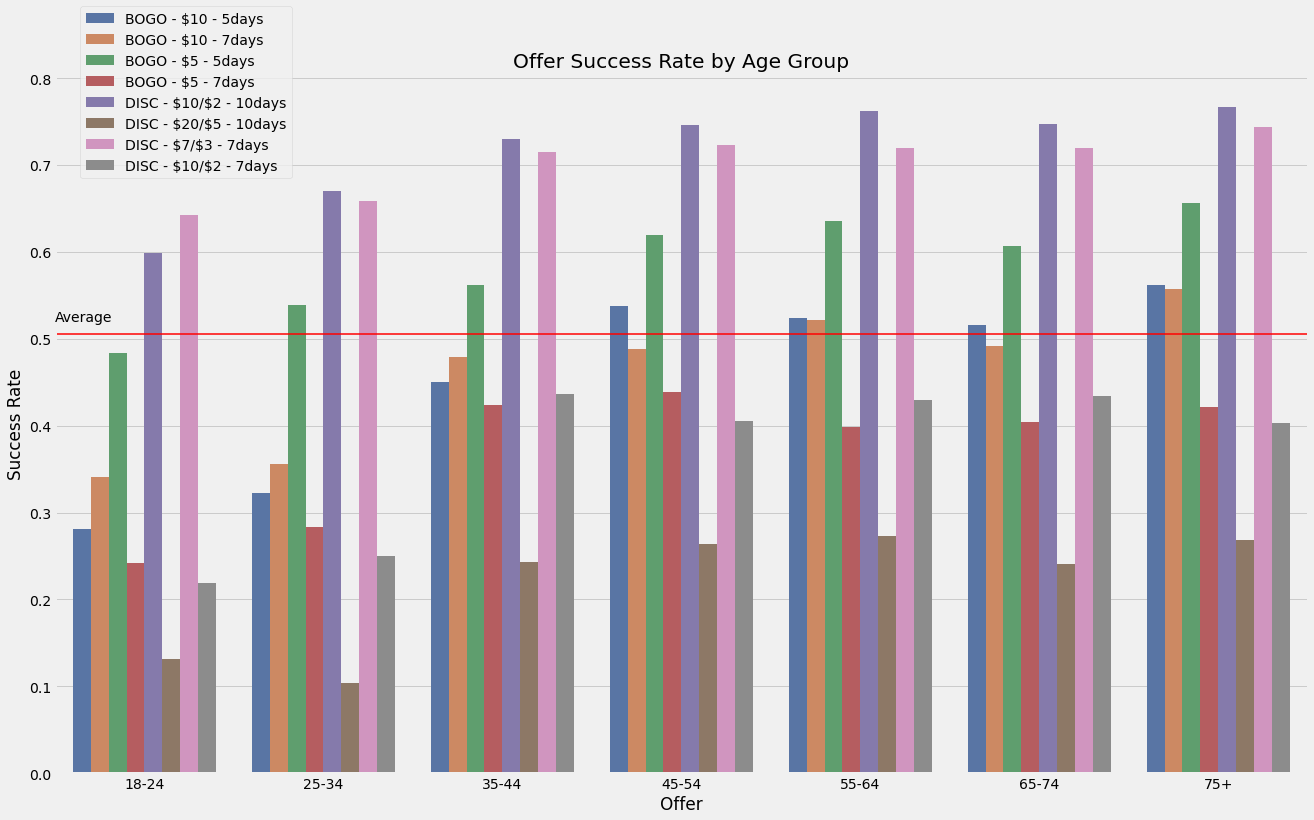

In [171]:
success_rate_by_age = bogo_disc_offers.groupby(['age_group', 'readable_id'])['offer_successful'].mean().reset_index()

avg_success_rate = bogo_disc_offers['offer_successful'].mean()


fig, ax = plt.subplots(figsize=(20,12))
sns.barplot(data = success_rate_by_age, x='age_group', y='offer_successful', hue='readable_id', ax=ax, palette='deep')
ax.set_ylabel('Success Rate')
ax.set_xlabel('Offer')
ax.set_title('Offer Success Rate by Age Group')

ax.axhline(avg_success_rate, color='red', linewidth=1.5)
ax.annotate('Average', (-0.5, 0.52))

plt.legend(loc=(0.02,0.85))


Across all age groups, the two offers with the highest success rate are the discount offers \\$10/\\$2/10-day and the \\$7/\\$3/7-day. 
The two offers with the lowest success rate are the remaining two discount offers (\\$20/\\$5/10-day and \\$10/\\$2/7-day). 


Among BOGO offers, the highest completed is the \\$5/5-day offer. The lowest success rate is for offer \\$5/7-day offer.


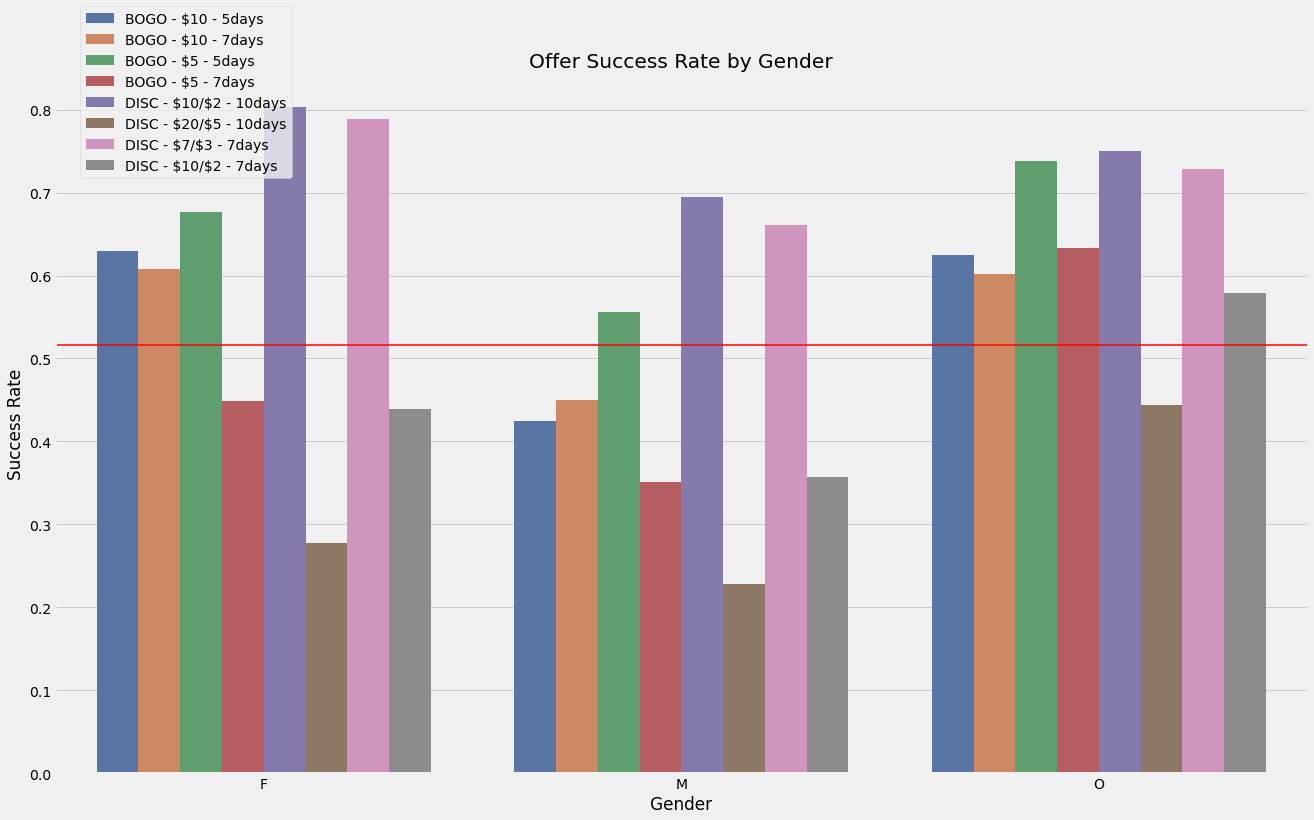

In [13]:
success_rate_by_gender = bogo_disc_offers.groupby(['gender', 'readable_id'])['offer_successful'].mean().reset_index()

avg_success_rate = bogo_disc_offers['offer_successful'].mean()


fig, ax = plt.subplots(figsize=(20,12))
sns.barplot(data = success_rate_by_gender, x='gender', y='offer_successful', hue='readable_id', ax=ax, palette='deep')
ax.set_ylabel('Success Rate')
ax.set_xlabel('Gender')
ax.set_title('Offer Success Rate by Gender')

ax.axhline(avg_success_rate, color='red', linewidth=1.5)

plt.legend(loc=(0.02,0.85))


For both male and female customers we see the two offers with the highest success rate are DISC-\\$10/\\$2/10day and DISC-\\$7/\\$3/7day. For gender other the two highest are DISC-\\$10/\\$2/10days and BOGO-\\$5/5day offers. 

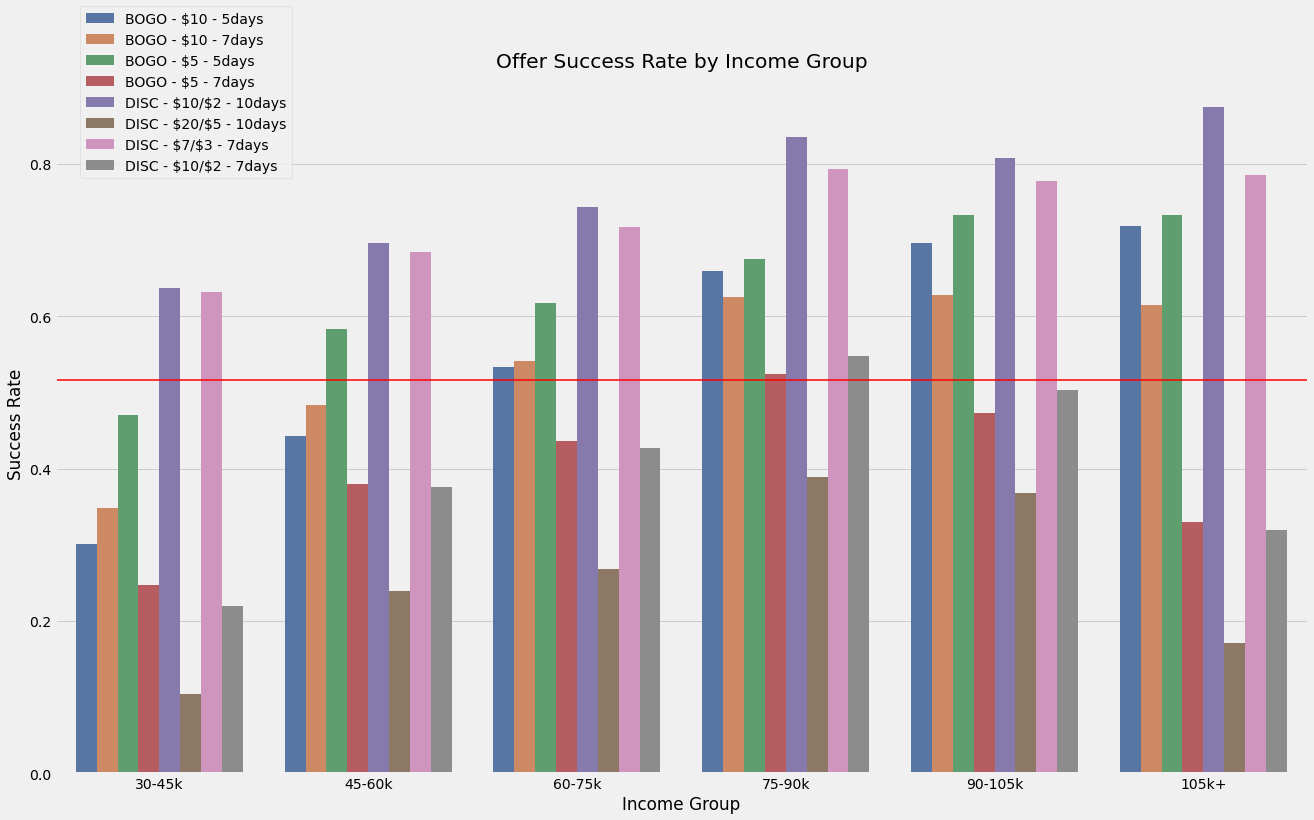

In [20]:
success_rate_by_income = bogo_disc_offers.groupby(['income_group', 'readable_id'])['offer_successful'].mean().reset_index()

avg_success_rate = bogo_disc_offers['offer_successful'].mean()
order=['30-45k', '45-60k', '60-75k', '75-90k', '90-105k', '105k+']

fig, ax = plt.subplots(figsize=(20,12))
sns.barplot(data = success_rate_by_income, x='income_group', y='offer_successful', hue='readable_id', ax=ax, palette='deep', order=order)
ax.set_ylabel('Success Rate')
ax.set_xlabel('Income Group')
ax.set_title('Offer Success Rate by Income Group')

ax.axhline(avg_success_rate, color='red', linewidth=1.5)

plt.legend(loc=(0.02,0.85))


In [33]:
sns.color_palette("light:b", as_cmap=True)

Across all income groups, the same two offers continue to have the highest success rates: DISC-\\$10/\\$2/10day and DISC-\\$7/\\$3/7day.

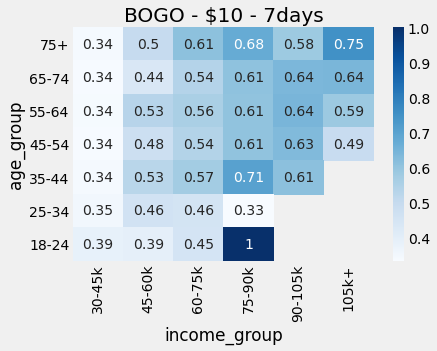

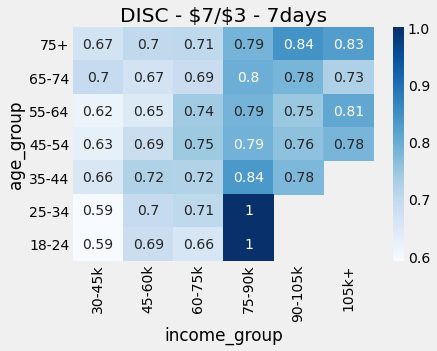

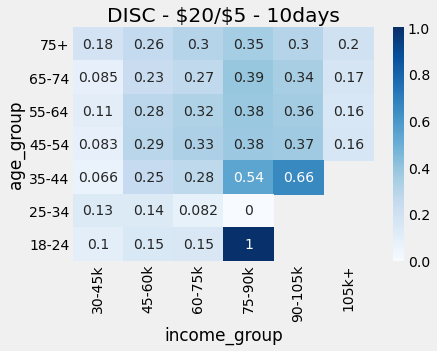

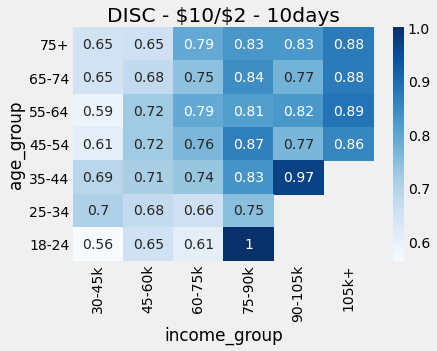

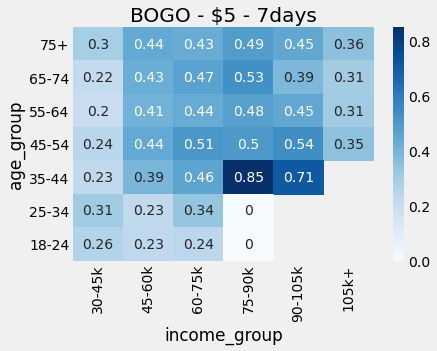

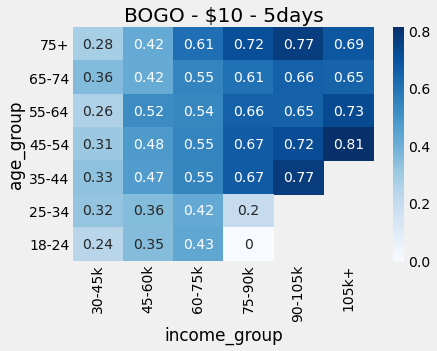

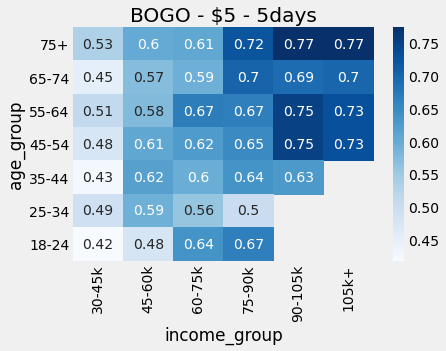

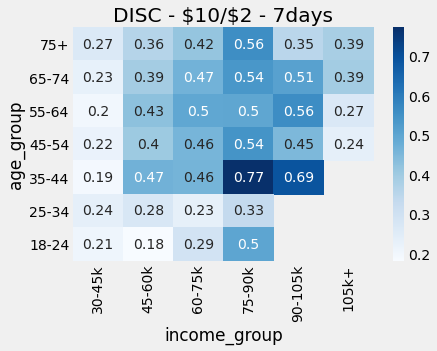

In [45]:
income_age_success_rate = bogo_disc_offers.groupby(['readable_id', 'income_group', 'age_group'])['offer_successful'].mean().reset_index().sort_values('offer_successful', ascending=False)

sns.color_palette()

for offer in income_age_success_rate['readable_id'].unique():
    data = income_age_success_rate.loc[income_age_success_rate['readable_id'] == offer]
    pivot_data = pd.pivot_table(data, index='age_group', columns='income_group', values='offer_successful')
    pivot_data = pivot_data[['30-45k', '45-60k', '60-75k', '75-90k', '90-105k', '105k+']].sort_index(ascending=False)
    ax = sns.heatmap(pivot_data, annot=True, cmap='Blues')
    ax.set_title(offer)
    plt.show()
    

income_group,30-45k,45-60k,60-75k,75-90k,90-105k,105k+
age_group,,,,,,
75+,0.344086,0.500000,0.611111,0.676471,0.584906,0.750000
65-74,0.337423,0.435345,0.538745,0.606796,0.638298,0.642857
55-64,0.339623,0.532258,0.557423,0.605096,0.643443,0.585938
45-54,0.338164,0.481707,0.540936,0.606426,0.631250,0.492537
35-44,0.344037,0.526923,0.573123,0.705263,0.614035,NaN
25-34,0.354545,0.461883,0.455497,0.333333,NaN,NaN
18-24,0.385714,0.393701,0.450980,1.000000,NaN,NaN


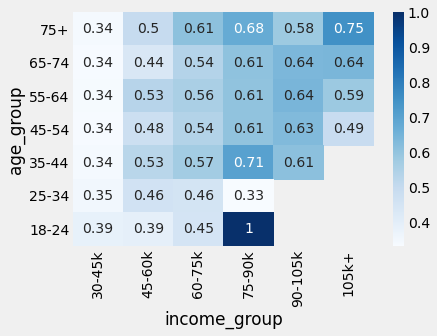

In [39]:
x = income_age_success_rate.loc[income_age_success_rate['readable_id'] == 'BOGO - $10 - 7days']

y = y[['30-45k', '45-60k', '60-75k', '75-90k', '90-105k', '105k+']].sort_index(ascending=False)
sns.heatmap(y, annot=True, cmap='Blues:b')
y

In [51]:
bogo_disc_offers.groupby(['readable_id', 'income_group', 'gender'])['offer_successful'].mean().reset_index().sort_values('offer_successful', ascending=False)

,readable_id,income_group,gender,offer_successful
50,BOGO - $5 - 5days,90-105k,O,0.888889
69,DISC - $10/\$2 - 10days,105k+,M,0.876106
68,DISC - $10/\$2 - 10days,105k+,F,0.874494
81,DISC - $10/\$2 - 10days,75-90k,O,0.857143
79,DISC - $10/\$2 - 10days,75-90k,F,0.842640
...,...,...,...,...
86,DISC - $20/\$5 - 10days,105k+,M,0.173554
85,DISC - $20/\$5 - 10days,105k+,F,0.169492
87,DISC - $20/\$5 - 10days,30-45k,F,0.149254
89,DISC - $20/\$5 - 10days,30-45k,O,0.130435


In [52]:
bogo_disc_offers.groupby(['readable_id', 'age_group', 'gender'])['offer_successful'].mean().reset_index().sort_values('offer_successful', ascending=False)

,readable_id,age_group,gender,offer_successful
89,DISC - $10/\$2 - 10days,25-34,O,1.000000
2,BOGO - $10 - 5days,18-24,O,1.000000
137,DISC - $7/\$3 - 7days,45-54,O,0.928571
53,BOGO - $5 - 5days,45-54,O,0.842105
47,BOGO - $5 - 5days,25-34,O,0.833333
...,...,...,...,...
107,DISC - $20/\$5 - 10days,18-24,O,0.166667
105,DISC - $20/\$5 - 10days,18-24,F,0.154545
108,DISC - $20/\$5 - 10days,25-34,F,0.143646
106,DISC - $20/\$5 - 10days,18-24,M,0.129278


In [53]:
bogo_disc_offers.loc[bogo_disc_offers['gender']!='O'].groupby(['readable_id', 'income_group', 'age_group', 'gender'])['offer_successful'].mean().reset_index().sort_values('offer_successful', ascending=False).head(30)

,readable_id,income_group,age_group,gender,offer_successful
354,DISC - $10/\$2 - 10days,90-105k,35-44,F,1.000000
196,BOGO - $5 - 5days,75-90k,18-24,F,1.000000
414,DISC - $20/\$5 - 10days,75-90k,18-24,F,1.000000
487,DISC - $7/\$3 - 7days,75-90k,18-24,F,1.000000
488,DISC - $7/\$3 - 7days,75-90k,18-24,M,1.000000
489,DISC - $7/\$3 - 7days,75-90k,25-34,F,1.000000
490,DISC - $7/\$3 - 7days,75-90k,25-34,M,1.000000
342,DISC - $10/\$2 - 10days,75-90k,18-24,M,1.000000
124,BOGO - $10 - 7days,75-90k,25-34,F,1.000000
123,BOGO - $10 - 7days,75-90k,18-24,M,1.000000


#### 2. What age_groups, income_groups, and genders spend the most after receiving and viewing an offer.

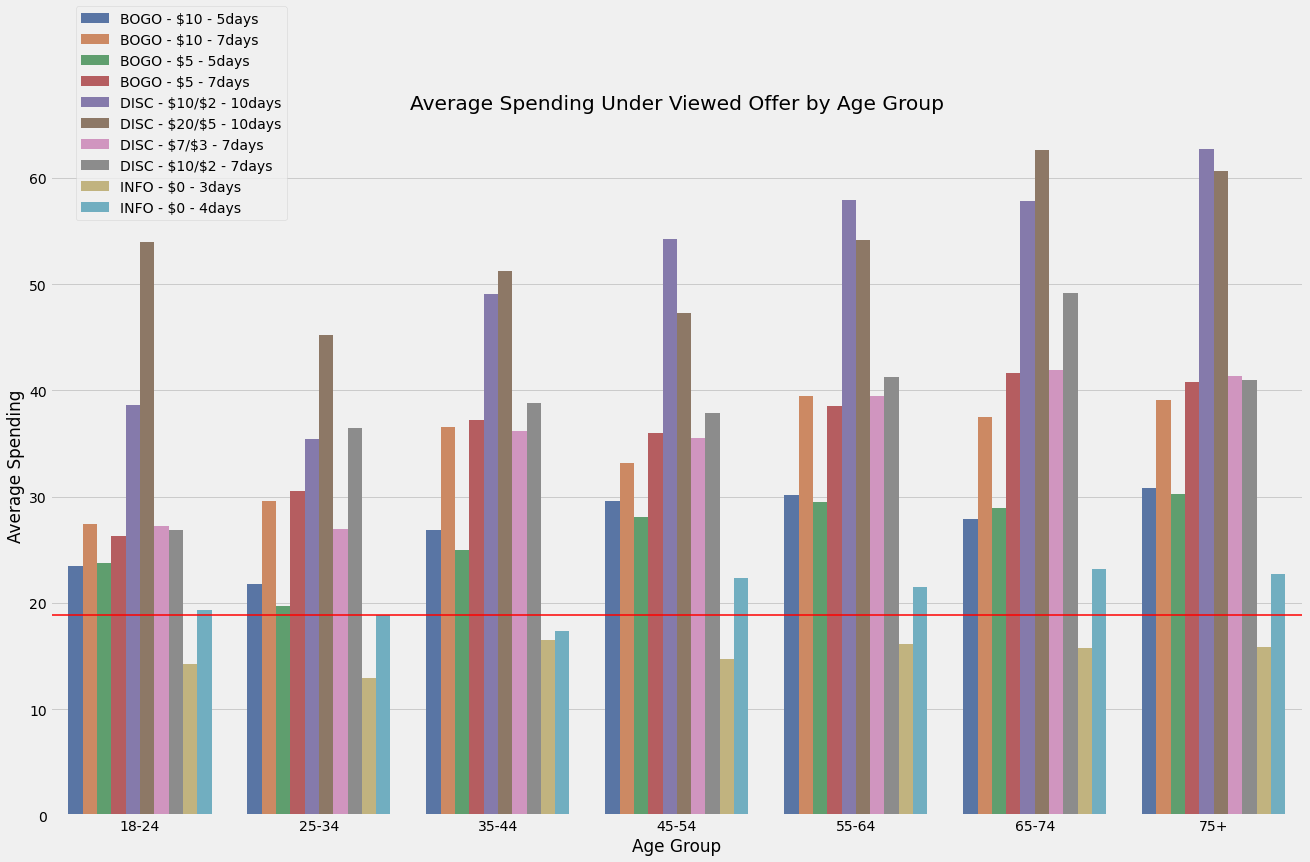

In [89]:
offers_viewed = master_df.loc[master_df['offer_viewed'] == 1]

avg_spending_by_age_viewed = offers_viewed.groupby(['readable_id', 'age_group'])['amt_spent_under_offer'].mean().reset_index()
avg_spending = master_df.loc[master_df['offer_viewed'] == 0, 'amt_spent_under_offer'].mean()


fig, ax = plt.subplots(figsize=(20,12))
sns.barplot(data = avg_spending_by_age_viewed, x='age_group', y='amt_spent_under_offer', hue='readable_id', ax=ax, palette='deep')
ax.set_ylabel('Average Spending')
ax.set_xlabel('Age Group')
ax.set_title('Average Spending Under Viewed Offer by Age Group')

ax.axhline(avg_spending, color='red', linewidth=1.5)

plt.legend(loc=(0.02,0.85))

For every age group, the two offers that users are spending the most money under are discount \\$10/\\$2/10-day and discount \\$20/\\$5/10-day

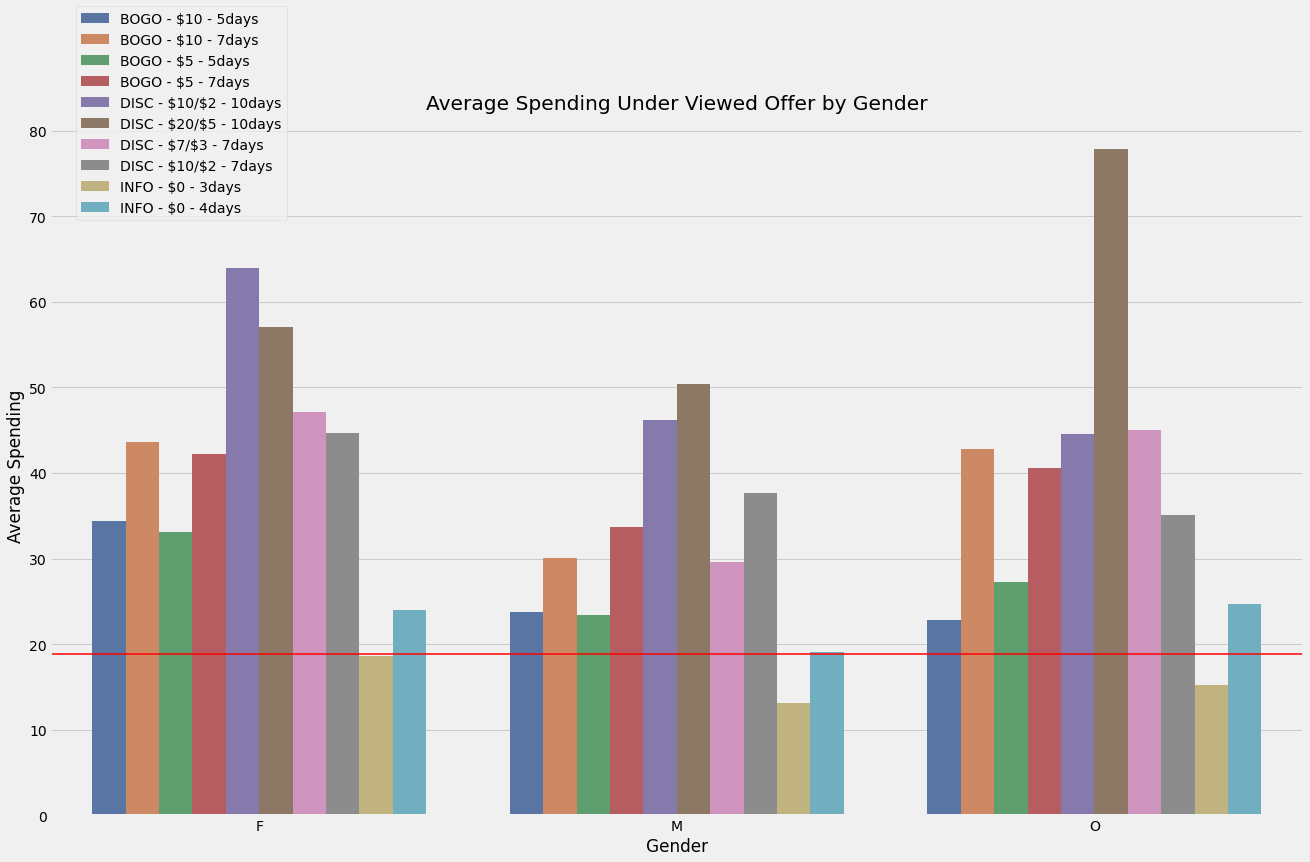

In [88]:
offers_viewed = master_df.loc[master_df['offer_viewed'] == 1]

avg_spending_by_gender_viewed = offers_viewed.groupby(['readable_id', 'gender'])['amt_spent_under_offer'].mean().reset_index()
avg_spending = master_df.loc[master_df['offer_viewed'] == 0, 'amt_spent_under_offer'].mean()


fig, ax = plt.subplots(figsize=(20,12))
sns.barplot(data = avg_spending_by_gender_viewed, x='gender', y='amt_spent_under_offer', hue='readable_id', ax=ax, palette='deep')
ax.set_ylabel('Average Spending')
ax.set_xlabel('Gender')
ax.set_title('Average Spending Under Viewed Offer by Gender')

ax.axhline(avg_spending, color='red', linewidth=1.5)

plt.legend(loc=(0.02,0.85))

In [100]:
def create_grouped_bar_chart(df=master_df, col_x='age_group', col_y='amt_spent_under_offer'):
    """Creates a grouped bar chart where col_x is on the x_axis and col_y is the metric we are measuring
    
    INPUTS:
    df: master_df dataframe
    col_x: column you want as categories on your x_axis
    col_y: column (numerical) you want as your metric
    
    OUTPUTS:
    Grouped Bar Chart 
    """
    # Subset only offers that were viewed
    offers_viewed = master_df.loc[master_df['offer_viewed'] == 1]

    # Group by readable_id and x, and find average y
    grouped_df = offers_viewed.groupby(['readable_id', col_x])[col_y].mean().reset_index()
    
    # Find average spending under offers that were not viewed for comparison purposes 
    avg_spending = master_df.loc[master_df['offer_viewed'] == 0, col_y].mean()


    fig, ax = plt.subplots(figsize=(20,12))
    
    if col_x == 'income_group':
        order = ['30-45k', '45-60k', '60-75k', '75-90k', '90-105k', '105k+'] 
        sns.barplot(data = grouped_df, x=col_x, y=col_y, hue='readable_id', ax=ax, palette='deep', order=order)
    else:
        sns.barplot(data = grouped_df, x=col_x, y=col_y, hue='readable_id', ax=ax, palette='deep')

    ax.set_ylabel('Average Spending')
    ax.set_xlabel(col_x)
    ax.set_title('Average Spending Under Viewed Offer by {}'.format(col_x))

    ax.axhline(avg_spending, color='red', linewidth=1.5)

    plt.legend(loc=(0.02,0.85))


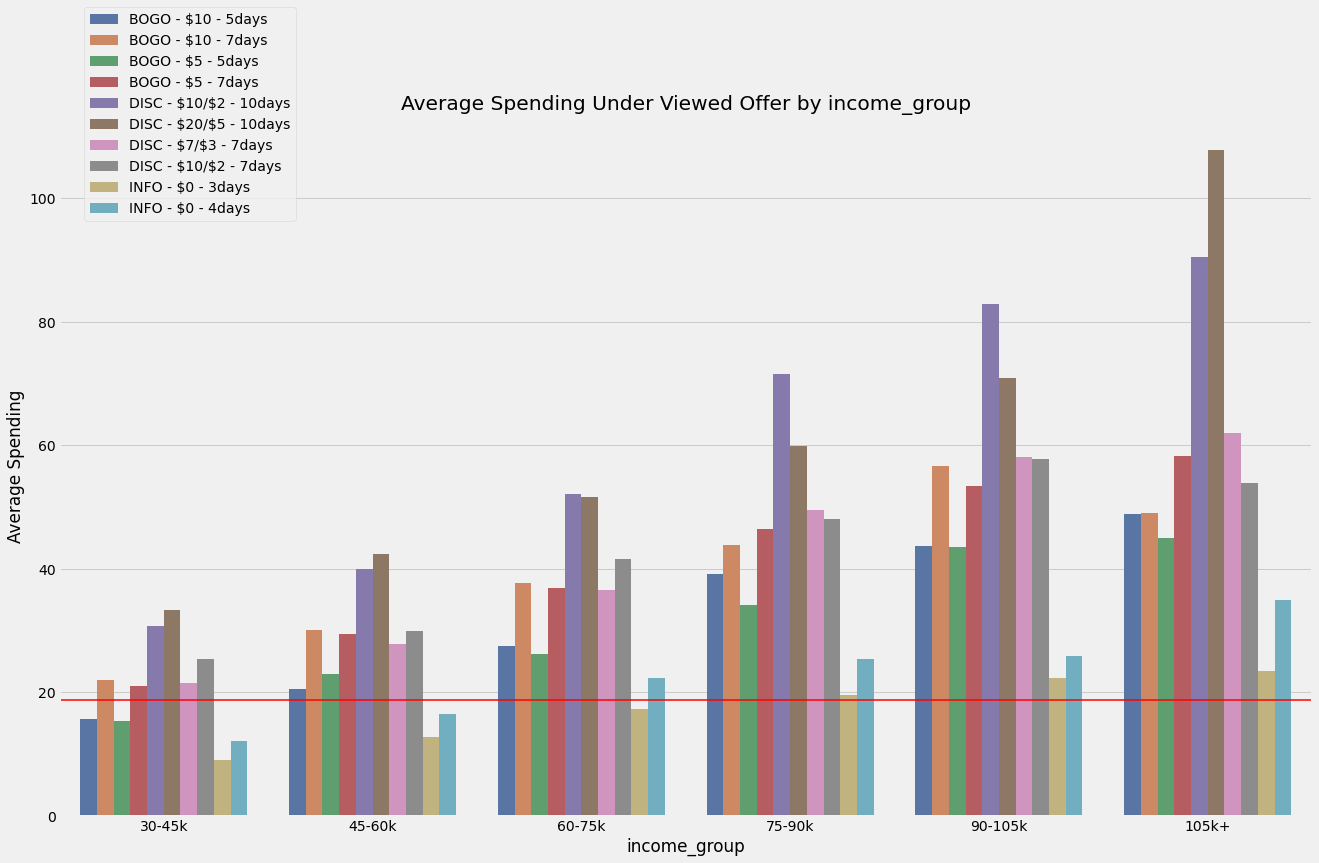

In [101]:
create_grouped_bar_chart(df=master_df, col_x='income_group', col_y='amt_spent_under_offer')

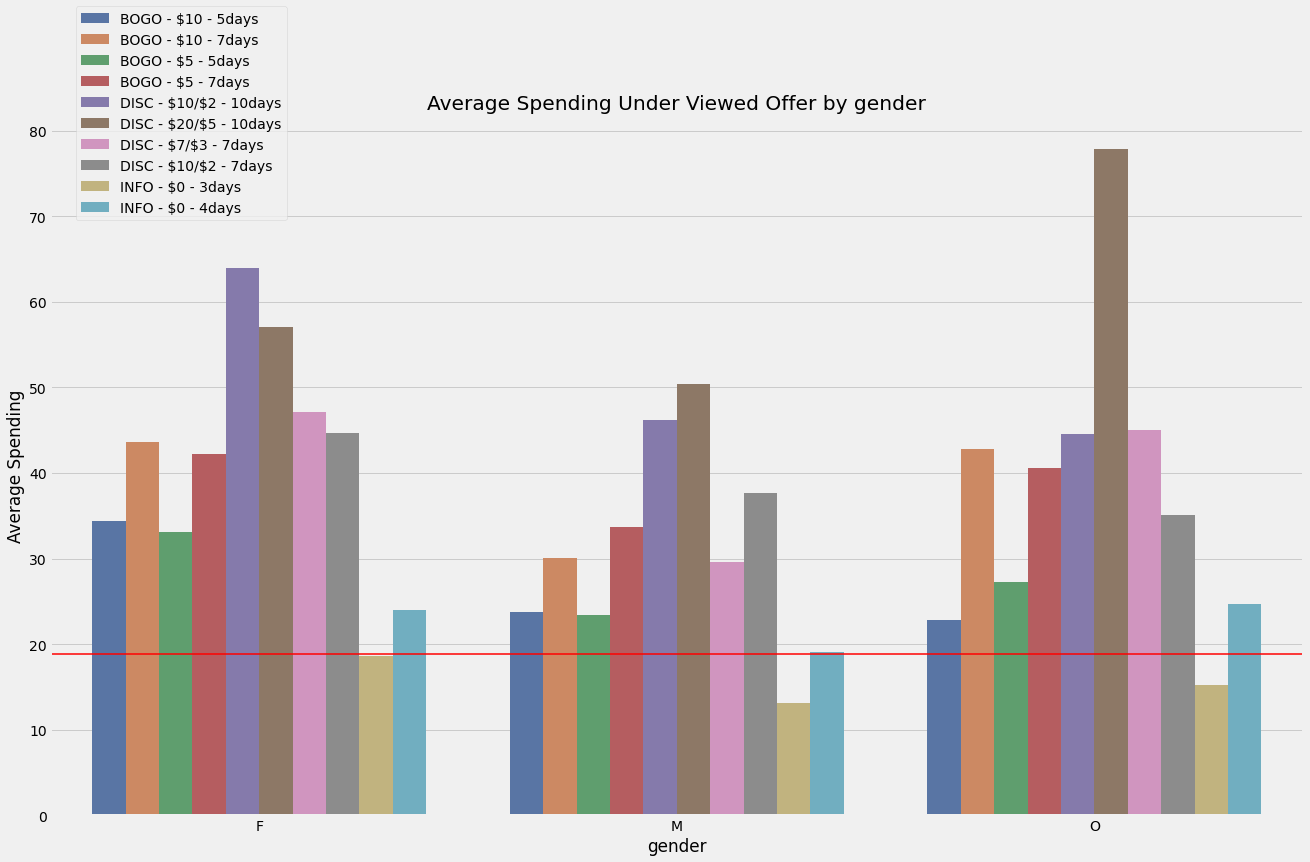

In [102]:
create_grouped_bar_chart(df=master_df, col_x='gender', col_y='amt_spent_under_offer')

#### 2. Under which offer type (BOGO, DISCOUNT, INFORMATIONAL) do customers spend the most?


In [220]:
amt_spent_offer_type_viewed

,offer_type,amt_spent_under_offer
0,bogo,31.476216
1,discount,45.451145
2,informational,17.569286


In [208]:
offers_viewed = master_df.loc[master_df['offer_viewed']==1]

amt_spent_offer_type_viewed = offers_viewed.groupby(['offer_type'])['amt_spent_under_offer'].mean().reset_index()
amt_spent_offer_type_viewed

avg_spending_offer_not_viewed = master_df.loc[master_df['offer_viewed']==0, 'amt_spent_under_offer'].mean()


Text(1.9, 20, 'average spent under \n non-viewed offers')

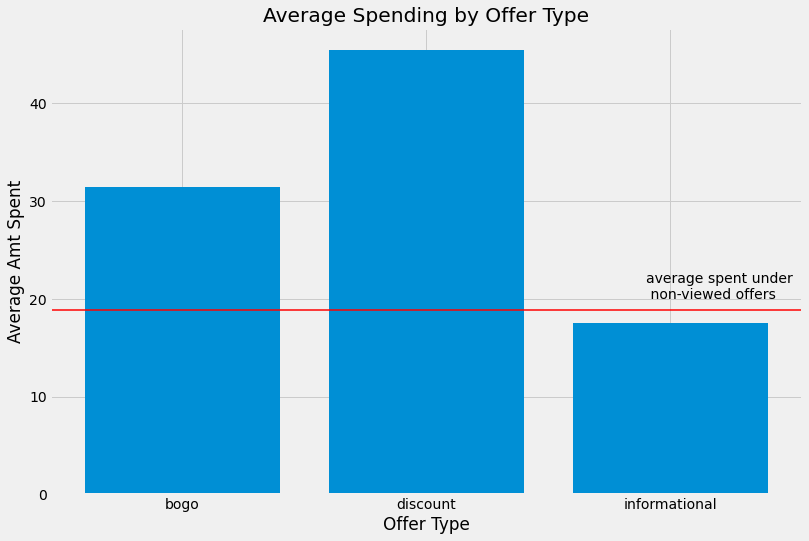

In [218]:
amt_spent_offer_type = master_df.groupby(['offer_type', 'offer_viewed'])['amt_spent_under_offer'].mean().reset_index()


fig, ax = plt.subplots(figsize=(12,8))

ax.bar(data=amt_spent_offer_type_viewed, x='offer_type', height='amt_spent_under_offer')
ax.axhline(avg_spending_offer_not_viewed, linewidth=1.5, color='red')
ax.set_title('Average Spending by Offer Type')
ax.set_xlabel('Offer Type')
ax.set_ylabel('Average Amt Spent')
ax.annotate('average spent under \n non-viewed offers', (1.9, 20))

Discounts elicit more spending than BOGO offers ($45 vs $31), but both of them elecit more spending than occured without viewing the offer. <br> Spending under informational offers was actually slightly lower than the average spending that occured without viewing an offer.

Text(0.5, 1.0, 'Average Transaction Amount per Offer Type')

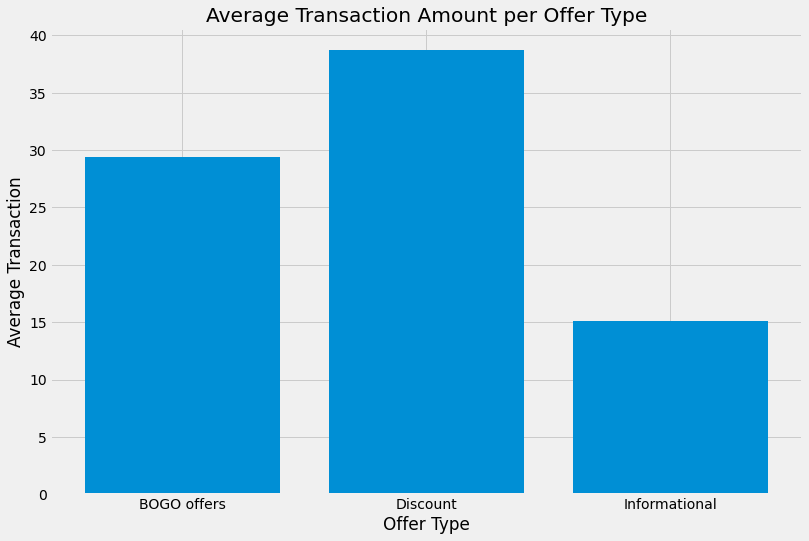

In [56]:
x = ['BOGO offers', 'Discount', 'Informational']
y = [avg_bogo_spending, avg_discount_spending, avg_info_spending]

fig, ax = plt.subplots(figsize=(12,8))
ax.bar(x, y)
ax.set_ylabel('Average Transaction')
ax.set_xlabel('Offer Type')
ax.set_title('Average Transaction Amount per Offer Type')

Overall it appears that among all the offers, the most money is spent under discount offers. 


In [231]:
master_df['num_offers'] = 0
for person in tqdm(master_df['person'].unique(), desc='Progress'):
    customer_data = master_df.loc[master_df['person'] == person]
    num_offers = customer_data.shape[0]
    master_df.loc[master_df['person'] == person, 'num_offers'] = np.arange(1,num_offers+1)
    
    

C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
Progress:   0%|                                                                              | 0/14821 [00:00<?, ?it/s]C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\pandas\core\indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
Progress: 100%|██████████████████████████████████████████████████

In [230]:
master_df.loc['num_offers'] = 0
master_df.loc[master_df['person'] == 'e4052622e5ba45a8b96b59aba68cf068', 'num_offers'] = np.arange(1,5)

master_df.loc[master_df['person'] == 'e4052622e5ba45a8b96b59aba68cf068']

C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\pandas\core\indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


,person,gender,age,became_member_on,income,year_joined,age_group,income_group,event,time,transaction_amt,readable_id,offer_type,difficulty,reward_y,duration,email,mobile,social,web,bogo,discount,informational,amt_spent_under_offer,offer_completed,offer_viewed,offer_valid_until,offer_successful,num_offers
272748,e4052622e5ba45a8b96b59aba68cf068,F,62.0,2017-07-22 00:00:00,82000.0,2017.0,55-64,75-90k,offer received,0,NaN,DISC - $7/\$3 - 7days,discount,7.0,3.0,7.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,68,1,1,168.0,1,1
272754,e4052622e5ba45a8b96b59aba68cf068,F,62.0,2017-07-22 00:00:00,82000.0,2017.0,55-64,75-90k,offer received,336,NaN,INFO - $0 - 4days,informational,0.0,0.0,4.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0,0,0,432.0,0,2
272755,e4052622e5ba45a8b96b59aba68cf068,F,62.0,2017-07-22 00:00:00,82000.0,2017.0,55-64,75-90k,offer received,408,NaN,BOGO - $5 - 5days,bogo,5.0,5.0,5.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,50,1,0,528.0,0,3
272760,e4052622e5ba45a8b96b59aba68cf068,F,62.0,2017-07-22 00:00:00,82000.0,2017.0,55-64,75-90k,offer received,576,NaN,INFO - $0 - 4days,informational,0.0,0.0,4.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0,0,0,672.0,0,4


In [223]:
list(range(1,5))

[1, 2, 3, 4]

#### 3. Does sending users more offers make them more likely to complete them?


In [453]:
table = pd.pivot_table(master_df, index=['readable_id'], columns=['age_group'], values=['offer_successful'], aggfunc=np.mean)
table.columns = table.columns.droplevel()
table

age_group,18-24,25-34,35-44,45-54,55-64,65-74,75+
readable_id,,,,,,,
BOGO - $10 - 5days,0.324519,0.363492,0.495037,0.554135,0.547020,0.531703,0.578419
BOGO - $10 - 7days,0.408108,0.421875,0.519819,0.515891,0.548243,0.520510,0.580645
BOGO - $5 - 5days,0.493857,0.547297,0.567367,0.623037,0.642484,0.609621,0.658537
BOGO - $5 - 7days,0.246753,0.287113,0.425606,0.441389,0.399220,0.405258,0.421581
DISC - $7/$3 - 7days,0.644928,0.662316,0.718714,0.724843,0.720077,0.720930,0.745387
DISC - \$10/\$2 - 10days,0.606557,0.679104,0.738007,0.751908,0.765783,0.750000,0.766965
DISC - \$10/\$2 - 7days,0.226328,0.249600,0.438813,0.405667,0.431715,0.434584,0.403822
DISC - \$20/\$5 - 10days,0.137203,0.117175,0.253837,0.283005,0.288917,0.253235,0.279951
INFO - $0 - 3days,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


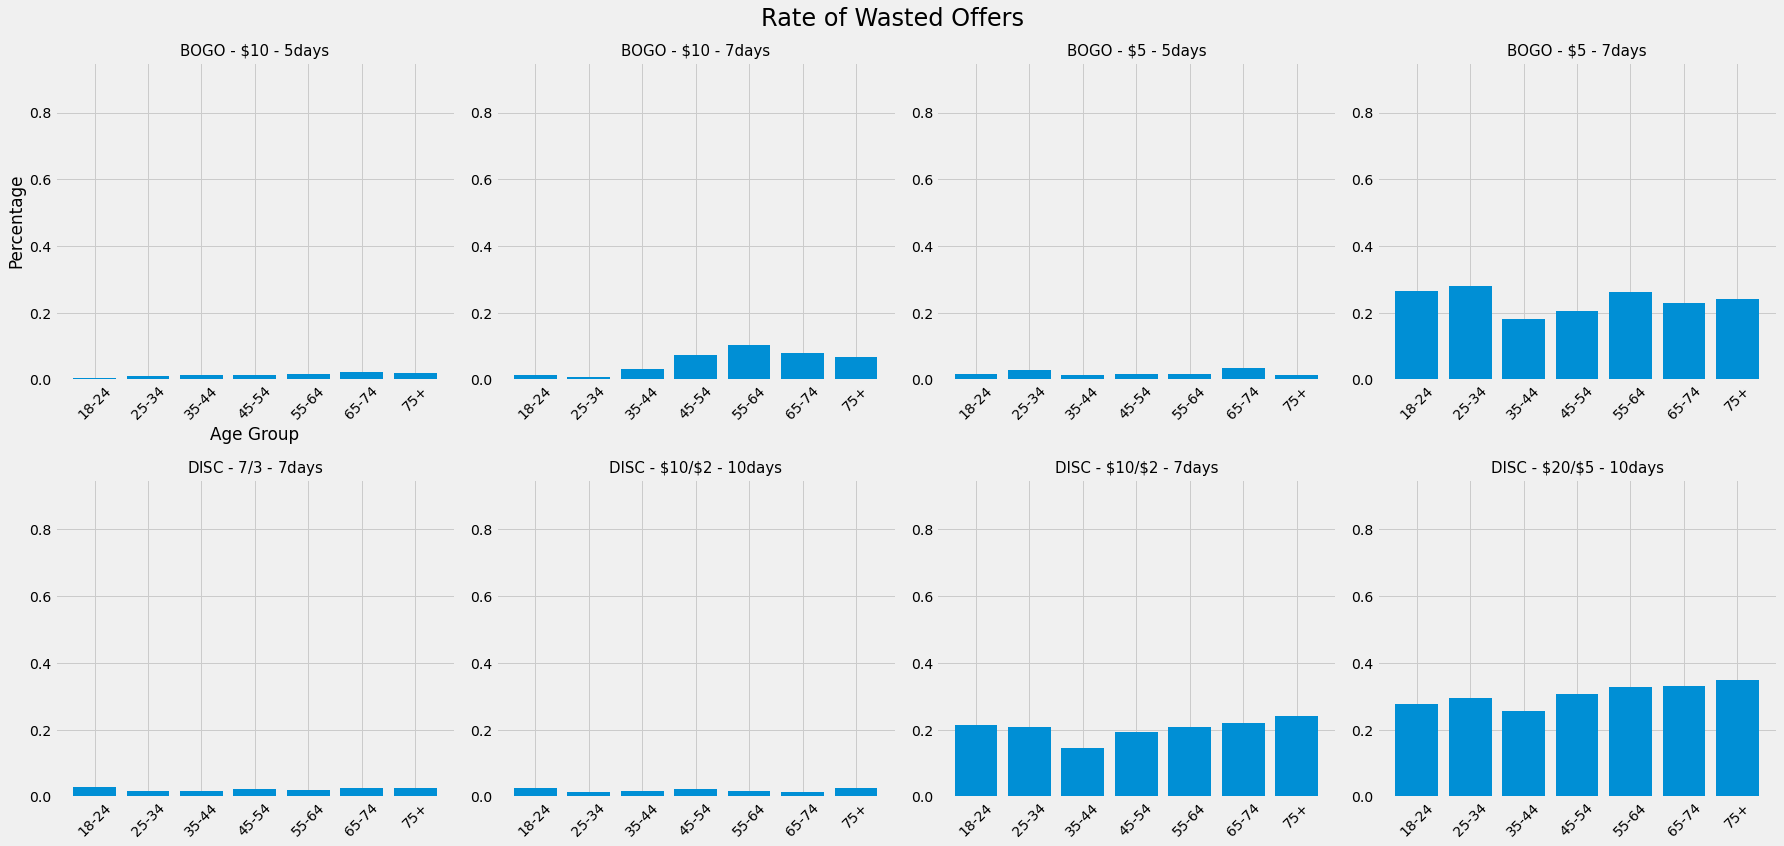

In [418]:
bogo_disc_offers = master_df.loc[master_df['informational'] == 0]
completed_not_viewed = bogo_disc_offers.loc[(bogo_disc_offers['offer_completed'] == 1) & (bogo_disc_offers['offer_viewed'] == 0)]
completed_not_viewed
wasted_offer_rate_by_age = completed_not_viewed.groupby(['readable_id', 'age_group'])['offer_completed'].sum().reset_index()
wasted_offer_rate_by_age['percent'] = wasted_offer_rate_by_age['offer_completed'] / bogo_disc_offers.groupby(['readable_id', 'age_group'])['offer_completed'].size().reset_index()['offer_completed']

wasted_offer_rate_by_age

fig = plt.figure(figsize=(25,12))

for i, offer in enumerate(np.sort(bogo_disc_offers['readable_id'].unique())):
    ax = fig.add_subplot(2, 4, i+1, sharey=ax)
    data = wasted_offer_rate_by_age.loc[wasted_offer_rate_by_age['readable_id'] == offer]
    x = data['age_group']
    y = data['percent']
    ax.bar(x, y)
    
    if i == 0:
        ax.set_xlabel('Age Group')
        ax.set_ylabel('Percentage')
    
    ax.set_title(data['readable_id'].iloc[0], fontsize=15)
    ax.tick_params(axis='x', rotation=45)

fig.suptitle('Rate of Wasted Offers', fontsize=24)
fig.tight_layout()

Takeaways:

1. It appears across all 8 offers, the 75+ demographic has the highest completion rates. 
2. The one exception is for the \\$5 and \\$10 BOGO offers that last 7 days, the 55-64 demographic are about equal to the 75+. 
3. The younger demographics (18-24 and 25-45) complete all the offers at lowest rates.
4. Overall, the older the customers are, the more likely they are to complete offers. 

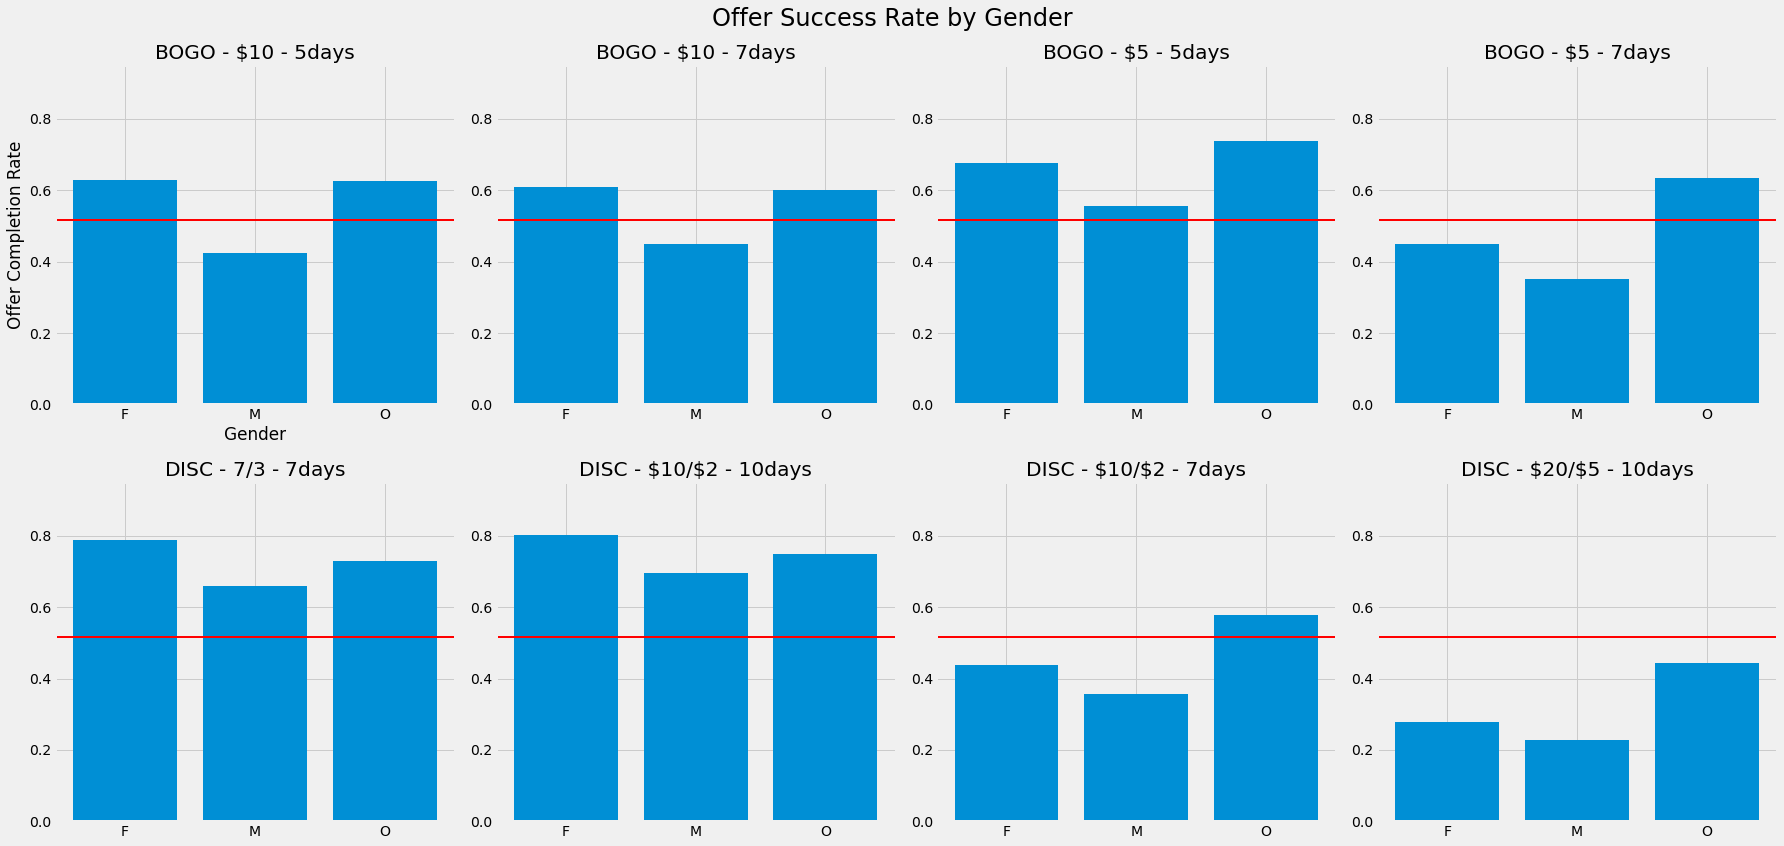

In [461]:
success_rate_by_gender = bogo_disc_offers.groupby(['readable_id', 'gender'])['offer_successful'].mean().reset_index()
avg_success_rate = bogo_disc_offers['offer_successful'].mean()

fig = plt.figure(figsize=(25,12))

for i, offer in enumerate(np.sort(bogo_disc_offers['readable_id'].unique())):
    ax = fig.add_subplot(2, 4, i+1, sharey=ax)
    data = success_rate_by_gender.loc[success_rate_by_gender['readable_id'] == offer]
    x = data['gender']
    y = data['offer_successful']
    ax.bar(x, y)
    
    if i == 0:
        ax.set_xlabel('Gender')
        ax.set_ylabel('Offer Completion Rate')
    
    ax.set_title(data['readable_id'].iloc[0])
    ax.axhline(avg_success_rate, color='red', linewidth=2)

fig.suptitle('Offer Success Rate by Gender', fontsize=24)
fig.tight_layout()

Across all offers, female customers have higher completion rates than male customers. In the BOGO\\$5 5 day and 7 day offer and the DISCOUNT \\$10/\\$2 and \\$20/\\$5 customers with gender O have highest rates of successful offers. It's important to note that gender O customers make up about 1\% of the customers in the experiment. so the sample size for those subsets are low. The \\$7/\\$3 off and \\$10/\\$2 off had particularly high rates of completion around 80% for female customers and just under 70% for male customers.


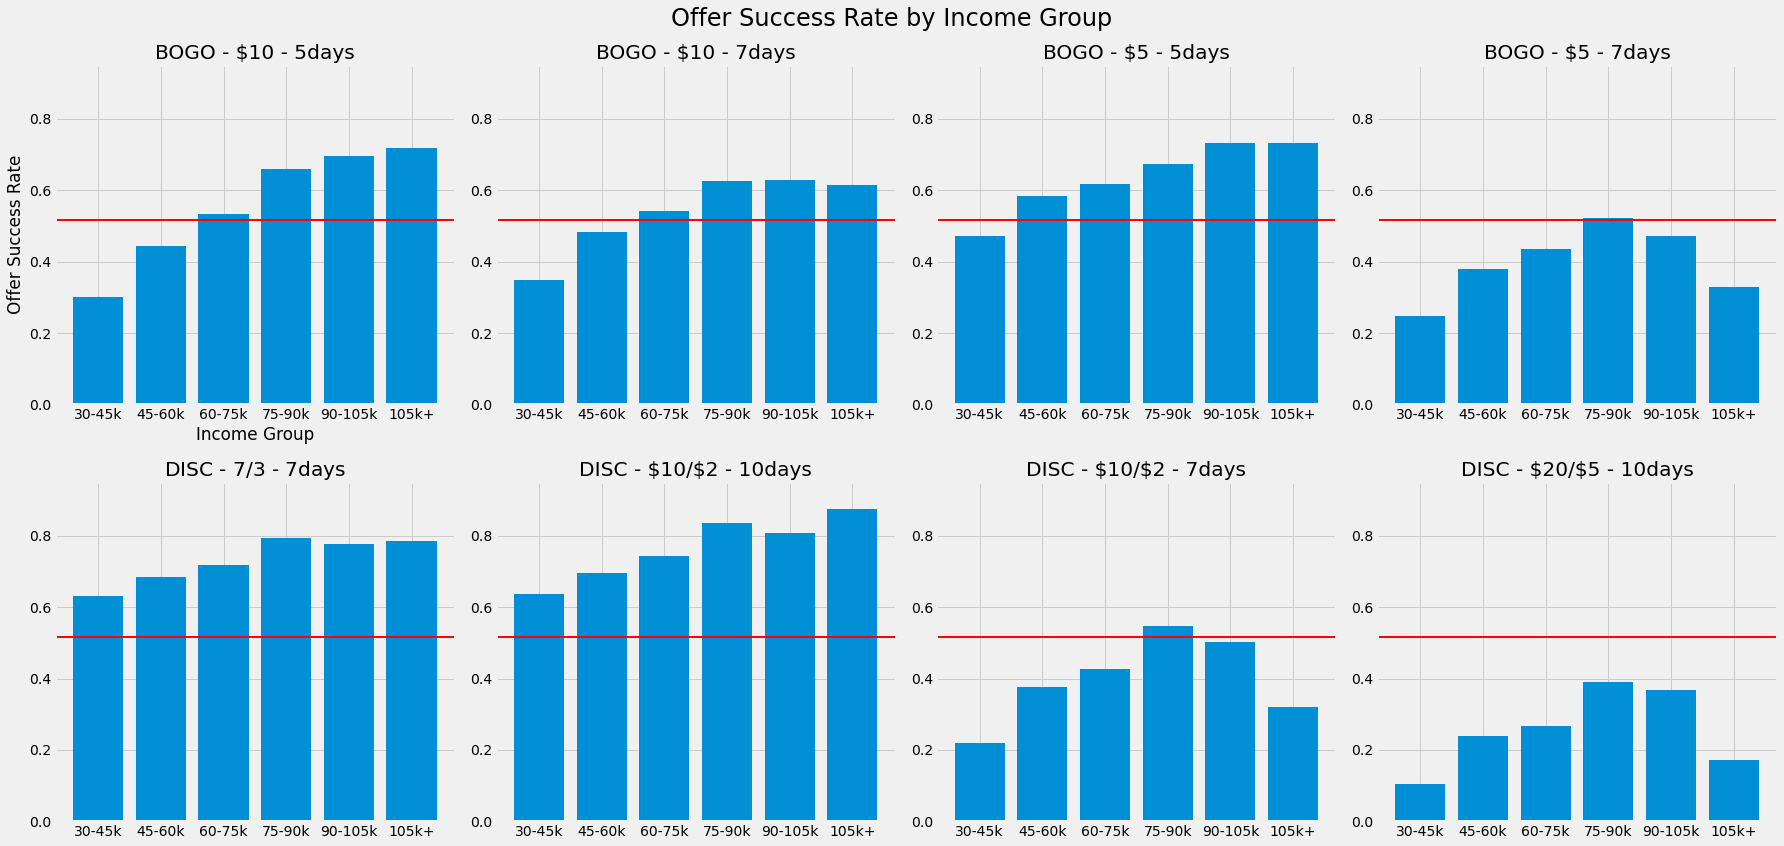

In [464]:
success_rate_by_income = bogo_disc_offers.groupby(['readable_id', 'income_group'])['offer_successful'].mean().reset_index()
avg_success_rate = bogo_disc_offers['offer_successful'].mean()
mapping = {'105k+':5, '90-105k':4, '60-75k':2, '45-60k':1, '30-45k':0, '75-90k':3,}

fig = plt.figure(figsize=(25,12))

for i, offer in enumerate(np.sort(bogo_disc_offers['readable_id'].unique())):
    ax = fig.add_subplot(2, 4, i+1, sharey=ax)
    data = success_rate_by_income.loc[success_rate_by_income['readable_id'] == offer]
    key = data['income_group'].map(mapping)

    x = data['income_group'].iloc[key.argsort()]
    y = data['offer_successful'].iloc[key.argsort()]
    
    ax.bar(x, y)
    
    if i == 0:
        ax.set_xlabel('Income Group')
        ax.set_ylabel('Offer Success Rate')
    
    ax.set_title(data['readable_id'].iloc[0])
    ax.axhline(avg_success_rate, color='red', linewidth=2)

fig.suptitle('Offer Success Rate by Income Group', fontsize=24)
fig.tight_layout()

In 5 offers (BOGO \\$10 - 5 days, BOGO \\$10 - 7 days, BOGO \\$5 - 5days, discount \\$7/\\$3 - 7days and discount \\$10/\\$2 - 10days), customers with higher income had higher rates of successful offers. In BOGO \\$5 - 7days, DISCOUNT \\$10/\\$2 - 7 days and DISCOUNT \\$20/\\$5 - 10 days, rates of successful completions rise until 75-90k, and then starts to decrease. 

In [273]:
master_df.loc[master_df['bogo'] == 1, 'transactions_under_offer'].mean()

nan

In [ ]:
Create a machine learning model that will predict how much a user with certain demographics will spend after receiving a given offer_type.

<AxesSubplot:xlabel='readable_id'>

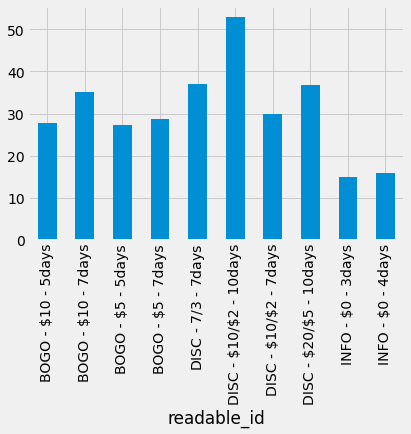

In [205]:
final_master_df.groupby(['readable_id'])['amt_spent_under_offer'].mean().plot.bar()

In [ ]:
final_master_df.grou

In [473]:
plt.style.use('fivethirtyeight')

C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\numpy\lib\histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\Jordan Nishimura\Anaconda3\lib\site-packages\numpy\lib\histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


Text(0, 0.5, 'Num Customers')

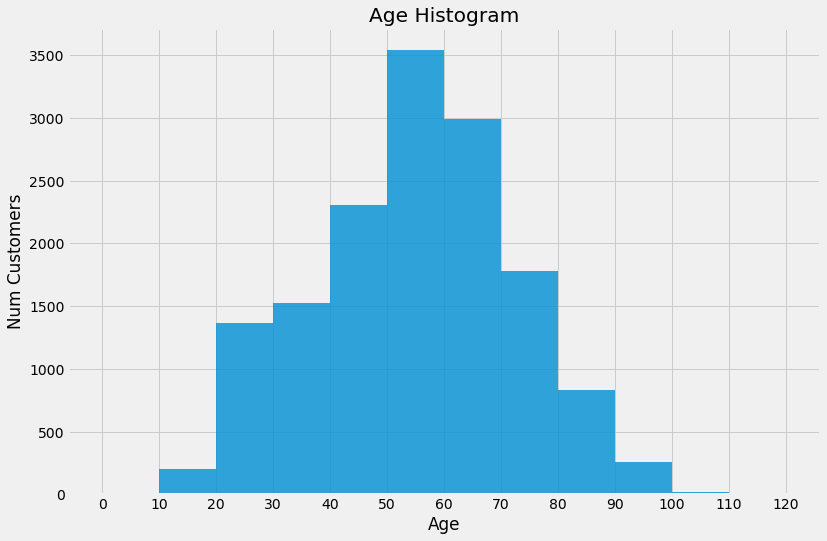

In [481]:
fig, ax = plt.subplots(figsize=(12,8));
x = profile['age'];
ax.hist(x, bins=12, range=(0,120), align='mid', alpha=0.8);
ax.set_xticks(range(0,121,10))
ax.set_title('Age Histogram')
ax.set_xlabel('Age')
ax.set_ylabel('Num Customers')

In [475]:
[str(x)[:-5] + 'k' for x in np.linspace(30000, 120000, 10)]



['30k', '40k', '50k', '60k', '70k', '80k', '90k', '100k', '110k', '120k']

Text(0, 0.5, 'Num Customers')

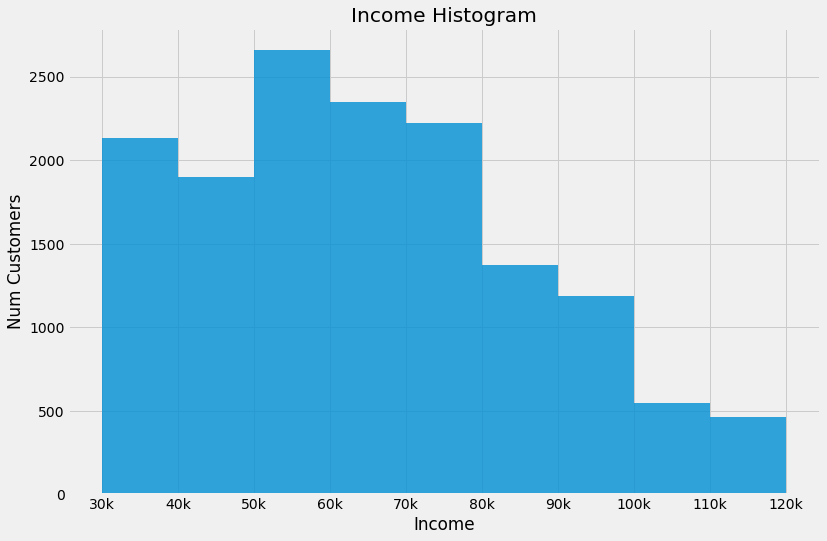

In [482]:
fig, ax = plt.subplots(figsize=(12,8));
x = profile['income'];
ax.hist(x, bins=9, range=(30000,120001), align='mid', alpha=0.8);
ax.set_xticks(np.linspace(30000, 120000, 10))
ax.set_xticklabels([str(x)[:-5] + 'k' for x in np.linspace(30000, 120000, 10)])
ax.set_title('Income Histogram')
ax.set_xlabel('Income')
ax.set_ylabel('Num Customers')


[Text(0, 0.0, '0%'),
 Text(0, 0.09999999999999999, '10%'),
 Text(0, 0.19999999999999998, '20%'),
 Text(0, 0.3, '30%'),
 Text(0, 0.39999999999999997, '40%'),
 Text(0, 0.49999999999999994, '50%'),
 Text(0, 0.6, '60%')]

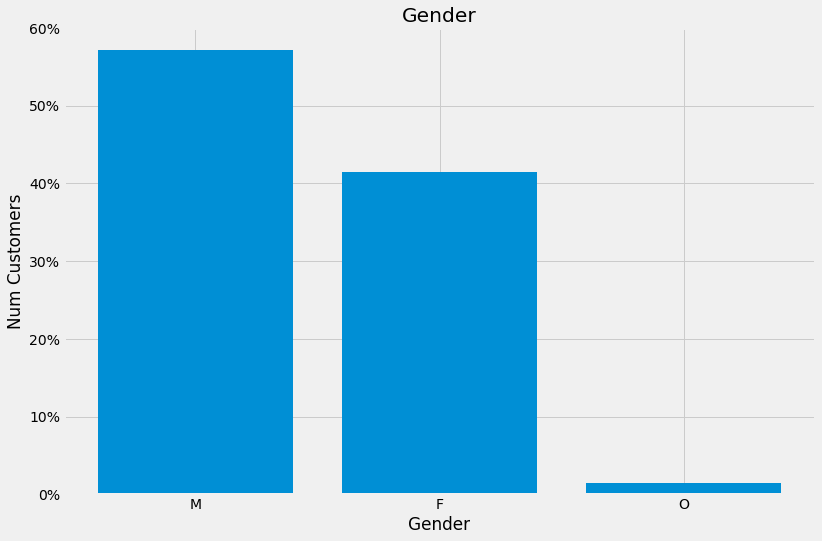

In [477]:
fig, ax = plt.subplots(figsize=(12,8))

data = df['gender'].value_counts(normalize=True).reset_index()
x = data['index'].tolist()
height = data['gender']

ax.bar(x=data['index'].tolist(), height=data['gender'].tolist())
ax.set_title('Gender')
ax.set_xlabel('Gender')
ax.set_ylabel('Num Customers')
ax.set_yticks(np.linspace(0,0.6,7))
ax.set_yticklabels("{:.0f}%".format(x) for x in np.linspace(0, 60, 7))

In [478]:
med_age = df['age'].median()
mean_age = df['age'].mean()

med_income = df['income'].median()
mean_income = df['income'].mean()

print("The median age is {}. The mean age is {:.1f}.".format(med_age, mean_age))
print("The median income is {}. The mean income is {:.1f}.".format(med_income, mean_income))

The median age is 55.0. The mean age is 53.8.
The median income is 62000.0. The mean income is 64337.0.


In [479]:
df['gender'].value_counts(normalize=True)

M    0.570791
F    0.414651
O    0.014558
Name: gender, dtype: float64

### Takeaways
The most common age group for starbucks customers is 50-59. The least common is 10-19 and 90-99. 
It appears they used 118 to mean the customers age is unknown, as there are 33772 instances of that age.

The most common income group is 50k to 60k, and the least common is 100k and above. 

There are more male customers (57%) than female customers (41%).

In [69]:
df[df['transaction_amt'] > 1000]

NameError: name 'df' is not defined

NameError: name 'df' is not defined

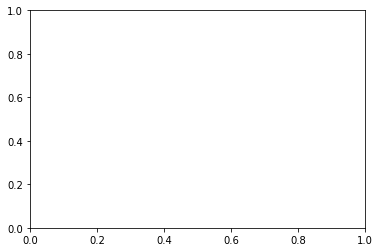

In [62]:
fig, ax = plt.subplots()

ax.hist(df['transaction_amt'], range=(0,50))
        

1. Frequency of transactions by gender, age, and income
2. Average Transaction amount by gender, age, and income
3. Total Spent in Experimeny by gender, age, and income

In [223]:
transactions = df.loc[df['event'] == 'transaction']
transactions.head()

,person,event,time,age,became_member_on,income,transaction_amt,offer_id,reward_received,channels,difficulty,duration,email,mobile,social,web,gender_F,gender_M,gender_O,offer_type_bogo,offer_type_discount,offer_type_informational
12654,02c083884c7d45b39cc68e1314fec56c,transaction,0,20,2016-07-11,30000.0,0.83,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,0,0,0,0
12657,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,transaction,0,42,2016-01-17,96000.0,34.56,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1,0,0,0,0
12659,54890f68699049c2a04d415abc25e717,transaction,0,36,2017-12-28,56000.0,13.23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1,0,0,0,0
12670,b2f1cd155b864803ad8334cdf13c4bd2,transaction,0,55,2017-10-16,94000.0,19.51,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,0,0,0,0
12671,fe97aa22dd3e48c8b143116a8403dd52,transaction,0,39,2017-12-17,67000.0,18.97,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,0,0,0,0


<AxesSubplot:xlabel='age_group'>

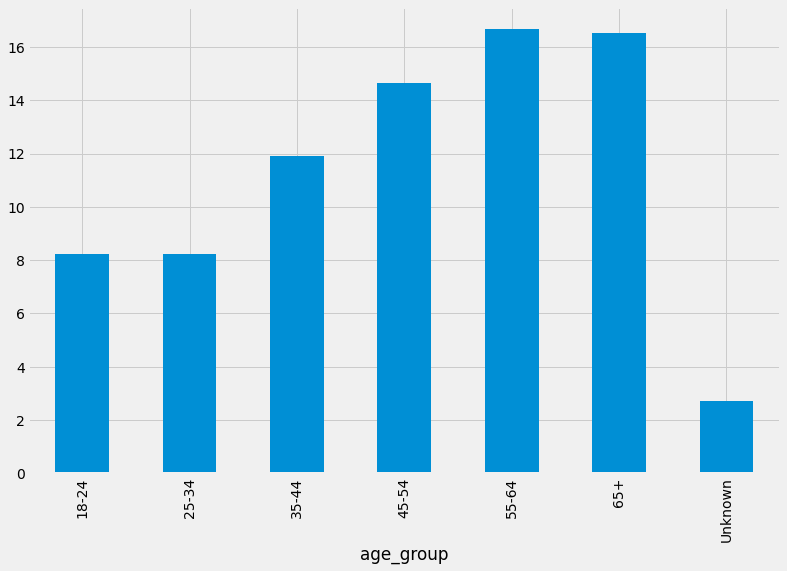

In [264]:
transactions.groupby(['age_group'])['transaction_amt'].mean().plot.bar(figsize=(12,8))

In [273]:
df.loc[df['person']== '1e9420836d554513ab90eba98552d0a9']

,person,event,time,age,became_member_on,income,transaction_amt,offer_id,reward_received,channels,difficulty,duration,email,mobile,social,web,gender_F,gender_M,gender_O,offer_type_bogo,offer_type_discount,offer_type_informational
19,1e9420836d554513ab90eba98552d0a9,offer received,0,22,2017-09-25,70000.0,NaN,ae264e3637204a6fb9bb56bc8210ddfd,NaN,"[email, mobile, social]",10.0,7.0,1.0,1.0,1.0,0.0,0,1,0,1,0,0
40779,1e9420836d554513ab90eba98552d0a9,offer viewed,96,22,2017-09-25,70000.0,NaN,ae264e3637204a6fb9bb56bc8210ddfd,NaN,"[email, mobile, social]",10.0,7.0,1.0,1.0,1.0,0.0,0,1,0,1,0,0
53196,1e9420836d554513ab90eba98552d0a9,offer received,168,22,2017-09-25,70000.0,NaN,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,"[web, email, mobile, social]",10.0,5.0,1.0,1.0,1.0,1.0,0,1,0,1,0,0
69328,1e9420836d554513ab90eba98552d0a9,offer viewed,174,22,2017-09-25,70000.0,NaN,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,"[web, email, mobile, social]",10.0,5.0,1.0,1.0,1.0,1.0,0,1,0,1,0,0
79426,1e9420836d554513ab90eba98552d0a9,transaction,198,22,2017-09-25,70000.0,17.11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
230416,1e9420836d554513ab90eba98552d0a9,offer viewed,534,22,2017-09-25,70000.0,NaN,3f207df678b143eea3cee63160fa8bed,NaN,"[web, email, mobile]",0.0,4.0,1.0,1.0,0.0,1.0,0,1,0,0,0,1
245143,1e9420836d554513ab90eba98552d0a9,offer received,576,22,2017-09-25,70000.0,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,"[web, email]",20.0,10.0,1.0,0.0,0.0,1.0,0,1,0,0,1,0
257891,1e9420836d554513ab90eba98552d0a9,offer viewed,576,22,2017-09-25,70000.0,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,"[web, email]",20.0,10.0,1.0,0.0,0.0,1.0,0,1,0,0,1,0
271788,1e9420836d554513ab90eba98552d0a9,transaction,600,22,2017-09-25,70000.0,28.82,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1,0,0,0,0


In [199]:
df.rename(columns={'reward_x':'reward_received', 'offer_type_y':'offer_type'}, inplace=True)


### Objectives
1. Predict how much a user will spend based on demographics and offer type.
2. Determine which demographics we should send which offers to. 
3. Which types of channels are are most effective and lead to customer purchases

In [202]:
df = pd.get_dummies(df, columns=['gender', 'offer_type'])


In [205]:
df['became_member_on'] = pd.to_datetime(df['became_member_on'], format='%Y%m%d')

determine if a transaction was made in the given duration


In [244]:
person_df = df.loc[df['person'] == '78afa995795e4d85b5d9ceeca43f5fef']
person_df.loc[(df['event'] == 'offer_viewed') | (df['event'] == 'offer_completed')]


,person,event,time,age,became_member_on,income,transaction_amt,offer_id,reward_received,channels,difficulty,duration,email,mobile,social,web,gender_F,gender_M,gender_O,offer_type_bogo,offer_type_discount,offer_type_informational


In [ ]:
def influenced_by_offer(person, df=df):
    for person in df['person'].unique():
        person_df = df.loc[df['person'] == person]
        
        
    
    